## Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [1]:
import os
import tempfile

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [2]:
#import modules, which consist of python command
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial

In [3]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
import scipy as sp




/home/hz368/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/hz368/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#load extensions
%load_ext line_profiler
%load_ext memory_profiler

In [5]:
'''
A cell should update to divide and die. As we can only count living cells, 
we only need to measure the lifetime of a cell or experiment, and store its 
siblings.

For the whole clone size, each of the siblings need to be simulated to their
stratification or the end of the experiment.

The cell updates in discrete time, with an aim that randomly generated times 
are projected back on a cohort a posteri to reduce calculation times.
'''
        
class cell:
    def __init__(self,init,stem,r,rng):
        self.currentTime = init
        self.stem = stem
        self.r = r
        self.rng = rng
        self.lifetime = 0
        self.birthtime = self.currentTime
        self.survivor = False
        self.siblings = []
    def printState(self):
        response = "Time\t%d\nStem\t%r\n" % (self.currentTime, self.stem)
        print(response)
    def printParameters(self):
        response = "Lambda\t%f\nr\t%f\nrho\t%f\n" % (self.lam, self.r, self.rho)
        print(response)
    def printHistory(self):
        response = "Siblings\t%d\tBirth\t%f\tDeath\t%f\n" % (len(self.siblings), self.birthtime, self.lifetime)
        print(response)
        
    def simulate(self,limit):
        cont = True
        while(cont):
            if self.lifetime > 0:
                cont = False
            elif self.currentTime>limit:
                if self.stem:
                    self.survivor = True
                    self.lifetime = self.currentTime
                else:
                    self.lifetime = self.currentTime+1
                cont = False
            else:
                if self.stem:
                    self.currentTime += 1
                    sibling = cell(self.currentTime,self.stem,self.r,self.rng)
                    rand = self.rng.random()
                    if rand < self.r:
                        pass
                    elif rand < (self.r*2):
                        self.stem = False
                        sibling.stem = False
                    else:
                        sibling.stem = False
                    self.siblings.append(sibling)
                else:
                    self.currentTime += 1
                    self.lifetime = self.currentTime
    
'''
Simulates a cell up to an event limit, storing the discrete times only
'''
def cloneSimulateDiscreteTime(i,limit,acc):
    i.simulate(limit)
    acc.append((i.birthtime,i.lifetime))
    for s in i.siblings:
        cloneSimulateDiscreteTime(s,limit,acc)
    return(acc)

'''
Simulates a cell up to an event limit, storing the cell as result
'''
def corecloneSimulateComplete(i,acc,parent,nameMarker,limit):
        i.simulate(limit)
        #update namemarker for a unique name
        nameMarker[0]+=1
        name = nameMarker[0]
        acc.append((i.birthtime,i.lifetime,parent,i.survivor)) #Switching to numpy array here leads to a 20x slowdown!
        for s in i.siblings:
            corecloneSimulateComplete(s,acc,name,nameMarker,limit)
        return((acc)) #adding np.asarray gives 20x slowdown
def cloneSimulateComplete(i,limit):
    return(corecloneSimulateComplete(i,[],-1,[-1],limit))

def experimentDiscreteTime(c,timePoints):
    limit = max(timePoints)
    lifespans = cloneSimulateDiscreteTime(c,limit,[])
    def within(a,b,c):
        if c>a and c<=b:
            return(1)
        else:
            return(0)
    return([sum([within(b,d,t) for (b,d) in lifespans]) for t in timePoints])
    

def printClone(c):
    def core(c,d):
        print("Gen\t%d" % d)
        c.printHistory()
        for i in c.siblings:
            core(i,d+1)
    core(c,0)

def seedExperiment(i):
    random.seed(i)
    return(experimentDiscreteTime(cell(0,True,0.25,random),[2,4,8,10,30,50,100]))

#uni = uniformGenerate(1982,None)
def seedClone(i):
    random.seed(i)
    return(cloneSimulateComplete(cell(0,True,0.25,random),100))

# Converting clone lifespan to realistic times

The fate simulator is able to generate the orders of events in a clones lifetime, but in order to compare this with experimental data we need to use the outputs from that function, and transform them into floating point numbers that reflect the division and stratification rates. The most common way to do this is to draw the division times from an exponential distribution characterised by its mean, but we also know that the exponential distribution is unrealistic for cell division times. Here we explore two alternative distributions used in the literature; a short, deterministic delay (the delay or refractory period) followed by an exponential distribution, and a deterministic lag period followed by times selected from a gamma distribution (with an additional shape parameter). As the exponential distribution is a special case of the gamma distribution where the shape is 1., we can focus on using just the gamma distribution when we start to compare with experimental data.

We first define functions that allow us to set create a random number generator for a given distribution with a specific set of parameters (using the numpy library to generate the underlying distribution). In each case the overall mean time for events to occur and a random number generator is passed to the function. In addition to this, a delay may be passed (either as an absolute delay, or expressed as a fraction of the mean) and a shape parameter. In each case the object returned is a function that takes unit as an input and returns a new floating point number from the distribution.

In each case we use an object that preallocates a large number of random numbers (*total*) and defines functions that return one, or an array of random numbers of a specified size, cumulatively summed. The functions that return values determine whether the store of numbers will run out and regenerates a set periodically. This is written like this for performance purposes. 

In [6]:
class timeGenerate:
    def __init__(self,seed,params):
#         np.random.seed(seed)
        self.total = 10000000
        self.params = params
        self.validate()
        #Generate "total" times
        self.regenerate()
    def regenerate(self):
        self.precalculated = np.ones(self.total)
        self.position = 0
    def next(self,n=1):
        if (n+self.position>self.total):
            self.regenerate()
            return(self.next(n))
        else:
            result = np.cumsum(self.precalculated[self.position:self.position+n])
            self.position+=n
            return(result)
    def nextOne(self):
        if (1+self.position>self.total):
            self.regenerate()
            return(self.nextOne())
        else:
            result = self.precalculated[self.position]
            self.position+=1
            return(result)
    def nextTerminated(self,n=1,terminator=None):
        if (n+self.position>self.total):
            self.regenerate()
            return(self.next(n))
        else:
            times = self.precalculated[self.position:self.position+n]
            #This replaces a value! it will not be reused and eventually will be regenerated though
            times[-1] = terminator.nextOne()
            result = np.cumsum(times)
            self.position+=n
            return(result)
    def validate(self):
        pass
    def drawTimes(self,limit):
        counter = 0
        totalTime=0
        while(totalTime<limit):
            totalTime+=self.precalculated[self.position+counter]
            counter+=1
            if counter+self.position>self.total:
                self.regenerate()
                return(self.drawtimes(limit))
        return(self.next(counter))
        

class halfTime(timeGenerate):
    def regenerate(self):
        self.precalculated = np.ones(self.total)/2
        self.position = 0
        
class exponentialGenerate(timeGenerate):
    def regenerate(self):
        (mean) = self.params
        self.precalculated = np.random.exponential(mean,self.total)
        #draw samples from an exponential distribution
        self.position = 0

class uniformGenerate(timeGenerate):
    def regenerate(self):
        #(lower,upper) = self.params
        self.precalculated = np.random.uniform(0,1,self.total)
        #draw samples from a uniform distribution
        self.position = 0

class exponentialGenerateDelay(timeGenerate):
    def regenerate(self):
        (mean,delay) = self.params
        self.precalculated = np.random.exponential((mean-delay),self.total)+delay
        self.position = 0
    def validate(self):
        assert(self.params[0]>self.params[1])

class gammaGenerate(timeGenerate):
    def regenerate(self):
        (shape,scale) = self.params
        self.precalculated = np.random.gamma(shape,scale,self.total)
        #draw samples from a gamma distribution
        self.position = 0

class gammaGenerateDelay(timeGenerate):
    def regenerate(self):
        (mean,shape,delay) = self.params
        scale = (mean-delay)/shape
        self.precalculated = np.random.gamma(shape,scale,self.total)+delay
        self.position = 0
    def validate(self):
        assert(self.params[0]>self.params[2])

#More elegant way of expressing the delay
class gammaGenerateFractionalDelay(timeGenerate):
    def regenerate(self):
        (mean,shape,delay) = self.params
        scale = (mean*(1-delay))/shape
        self.precalculated = np.random.gamma(shape,scale,self.total)+delay*mean
        self.position = 0
    def validate(self):
        assert(0<=self.params[2])
        assert(self.params[2]<=1)

In [7]:
def correctTime(c,initial,division,stratification,limit):
    eventTimes = [((division.next(d-b),b,d,p) if s else (division.nextTerminated(d-b,terminator=stratification),b,d,p) ) for (b,d,p,s) in c ]
    
    #Second correct the intial times of all of the events and store to the acc
    def includeBirth(times,birthday,deathday,parent):
        if parent<0:
            #special case- the initial cell
            times+=initial
            return((initial,times[-1])) 
        else:
            parentBirthday = eventTimes[parent][1]
            timeOnBirth=eventTimes[parent][0][birthday-parentBirthday-1]
            if(len(times)):
                times+=timeOnBirth
                return( (timeOnBirth, times[-1] ) )
            else:
                #special case- this is a cell born on the last time point. Arbitrarily set to infinity
                #Note differentiated cells born on the last timepoint have their lifetime extended, so this is only stem cells
                return((timeOnBirth,math.inf))
    acc = [includeBirth(times,birthday,deathday,parent) for (times,birthday,deathday,parent) in eventTimes]
    #times = nextTerminated(deathday - birthday, terminator = stratification) if survival = FALSE
    
    return(acc)

In [8]:
def printTime(c,initial,gen):
    print("Gen %d" % gen)
    birth = c.birthtime
    death = c.lifetime
    timePoints = death-birth
    realTimes = getTimes(timePoints,initial)
    print(realTimes)
    response = "Siblings\t%d\tBirth\t%d/%f\tDeath\t%d/%f\n" % (len(c.siblings), birth, initial, death, realTimes[-1])
    print(response)
    for i,t in zip(c.siblings,realTimes):
        printTime(i,t,gen+1)

## Comparing models with experiments
Here we will take the simulators we have created and use them to search an experimental dataset for parameters that describe the model well. We will take some published data of measured clone sizes, make a plot to show that it has some of the expected properties (specifically, linearly increasing average clone size over time). We will then use a set of simulations to estimate the likelihoods of different parameter combinations for models, and identify the most likely combination by plotting the results as a heatmap.

To interpret the heatmaps, the parameter combinations with the highest likelihood are the best fitting. For this dataset, we can see that for both exponential and gamma distributions we find low values of $r$ and high values of $\rho$ best describe the data. We can further see that the choice of distribution makes subtle differences on the long term distributions.

In [9]:
def getLineage(filename):
    #reads a tsv file of clone counts
    df = pd.read_csv(filename, sep="\t")
    counts = np.transpose(df.values).astype(float)
    header = df.columns.values
    return(header[1:].astype(float),counts[1:])

In [10]:
times, counts = getLineage("DoupeAggregate.tsv")

In [11]:
experiment = [[np.repeat(i+1, counts[t][i]) for i in range(max(np.where(counts[t]>0)[0]))] for t in range(len(counts))]
experimentList = [np.concatenate(t, axis = None) for t in experiment]
experimentList[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3])

In [12]:
def pad(a):
    topSize = max([len(i) for i in a])
    def complete(s):
#         result = (np.ones(topSize)*np.nan)
        result = (np.zeros(topSize))
        result[0:len(s)] = s
        return(result)
    return(np.array([complete(i) for i in a]))

def stripNaN(a):
    return(a[~np.isnan(a)])

In [13]:
# Distance functions measure closeness of observed and sampled data
def distance(sim,data):
    #return(np.nanmin(np.log2(a)-np.log2(b))**2)
    if np.isinf(sim["i"]).any():
        return(np.inf)
    else:
        #return(0)
        simData = sim["i"]
        #print(simData)
        d = sp.absolute(np.nanmin(simData-data["i"]))
        return(np.sum(d))

# def quantileStatistic(o,m):
#     #piedrafita summary stat
#     oq = np.quantile(o,[0.025,0.25,0.5,0.75,0.975])
#     mq = np.quantile(m,[0.025,0.25,0.5,0.75,0.975])
#     r = sp.absolute(oq-mq)
#     #print("o",oq)
#     #print("m",mq)
#     #print(r)
#     return(sum(r))  

def quantileStatistic(o,m):
    #piedrafita summary stat
#     [a for a in o if a >0],[b for b in m if b > 0]
    oq = np.quantile([a for a in o if a > 0],[0.025,0.25,0.5,0.75,0.975])
    mq = np.quantile([b for b in m if b > 0],[0.025,0.25,0.5,0.75,0.975])
    r = abs(oq-mq)
    #print("o",oq)
    #print("m",mq)
    #print(r)
    return(sum(r))
        
def ksStatistic(o,m):
    #print("%dx%d\n" % (len(o), len(m)) )
    k,p = stats.ks_2samp(o,m)
    return(k)

# def distancePopulation(summStat,sim,data):
#     if np.isinf(sim["cloneSize"]).any():
#         return(np.inf)
#     else:
#         modelResults = sim["cloneSize"]
#         observations = data["cloneSize"] 
#         results = [summStat(stripNaN(observations[i]),np.array(modelResults)[i]) for i in range(len(data))]
#         #print(results)
#         return(sum(results))
    
def distancePopulation(summStat,sim,data):
    if np.isinf(sim["cloneSize"]).any():
        return(np.inf)
    else:
        modelResults = sim["cloneSize"]
        observations = data["cloneSize"] 
        results = [summStat(observations[i],modelResults[i]) for i in range(len(observations))]
        print(sum(results))
        return(sum(results))

In [14]:
# x=np.array([np.quantile(counts[i],[0.025,0.25,0.5,0.75,0.975]) for i in range(len(counts))])
# y=np.array([np.quantile(sim0[i],[0.025,0.25,0.5,0.75,0.975]) for i in range(len(sim0))])
# r=x-y
# sum([sum(i) for i in r])

In [15]:
# def sizesToFreq(sizes):
#     biggest = max([max(c) for c in sizes])
#     sizeList = [[t.count(s+1) for s in range(biggest)] for t in sizes]
#     return(sizeList)
    
def fateToCloneSize(timePoints,fates,generations,div,strat):
    times = np.asarray([np.asarray(correctTime(c,0,div,strat,generations)) for c in fates])
    def within(birth,death,time):
        if time>=birth and time<death:
            return(1)
        else:
            return(0)
    cloneSizes = [[sum([within(cell[0],cell[1],t) for cell in clone]) for clone in times ] for t in timePoints]
#     freq = sizesToFreq(cloneSizes)
    return(cloneSizes)

def parameterLike(rho,meanDivTime,timePoints,fates,generations,div,seed):
    stratTime = (1-rho)*meanDivTime/rho
    strat = exponentialGenerate(seed,(stratTime)) 
    count = fateToCloneSize(timePoints,fates,generations,div,strat)
    return(count)

def cloneSimulation(timePoints,r,rho,sampleSize,div,meanDivTime):
    seed = 50
    random.seed(seed)
    generations = 230 
    def seedWrapper(r,generations,seed):
        random.seed(seed)
        clone = cell(0,True,r,random)
        return(cloneSimulateComplete(clone,generations))
    fates = np.asarray( [np.asarray(seedWrapper(r,generations,i)) for i in range(sampleSize)] )
    def within(birth,death,time):
        if time>=birth and time<death:
            return(1)
        else:
            return(0)
    cloneSizes = [[sum([within(b,d,t/meanDivTime) for (b,d,p,s) in clone]) for clone in fates ] for t in timePoints]
    return(parameterLike(rho,meanDivTime,timePoints,fates,generations,div,seed))
    
def cloneModel(p):
    div = exponentialGenerate(102,(2.4))
#     div = gammaGenerateDelay(102,(2.4,8.,0.5))
    meanDivTime = 2.4
#     rhoVals = [(i/bins+0.5/bins) for i in range(bins)] 
#     rVals = [(i/(2*bins)+0.25/bins) for i in range(bins)] 
    rhoVals = p["rho"]
    rVals = p["r"]
    timePoints = [3,10,21,42,84,180,365]
    sampleSize = 400
    freq = np.array(cloneSimulation(timePoints,rVals,rhoVals,sampleSize,div,meanDivTime))
#     prob = [(t/sum(t)) for t in freq]
#     expCloneN = [140,253,300,253,351,345,214]
#     result = [(a*b) for a,b in zip(prob,expCloneN)]
    return{"cloneSize": freq}

## Testing the simulator and distance functions

Here we run through a single set of model simulations with selected parameters to confirm that the functions work correctly together. These outputs can be directly compared with those from the F# code, and be found to give similar results, showing that the results are reproducible.

In [16]:
e0 = cloneModel({"rho": 0.1, "r": 0.4})
sim0 = e0["cloneSize"]
e1 = cloneModel({"rho": 0.6, "r": 0.4})
sim1 = e1["cloneSize"]
distancePopulation(quantileStatistic,e0,{"cloneSize": pad(experimentList)})
# distancePopulation(quantileStatistic,e1,{"cloneSize": pad(counts)})
# distancePopulation(quantileStatistic,e0,e0)

[4.400000000000006, 16.94999999999999, 37.625, 89.0, 272.0999999999996, 876.0999999999999, 1367.7500000000005]


2663.925

In [17]:
t=6
quantileStatistic(sim0[t],experimentList[t])

1367.7500000000005

In [18]:
range(len(sim0))

range(0, 7)

In [19]:
distancePopulation(quantileStatistic,e0,{"cloneSize": experimentList})

[4.400000000000006, 16.94999999999999, 37.625, 89.0, 272.0999999999996, 876.0999999999999, 1367.7500000000005]


2663.925

In [20]:
# width = 0.8

# t=1

# ad=max(np.where(sim0[t]>0)[0])
# bd=max(np.where(counts[t]>0)[0])

# if ad>=bd:
#     a=sim0[t][0:ad]
#     b=np.append([counts[t][0:bd]], [np.zeros(ad-bd)])
# else:
#     a=np.append([sim0[t][0:ad]], [np.zeros(bd-ad)])
#     b=counts[t][0:bd]

# indices = np.arange(len(a))

# plt.bar(indices, a, width=width, 
#         color='c', label='Sim 0')
# plt.bar([i+0.25*width for i in indices], b, 
#         width=0.5*width, color='g', alpha=0.5, label='counts')

# plt.xticks(indices+width/2., 
#            ['T{}'.format(i) for i in range(len(sim0[t]))] )

# plt.legend()
# plt.show()

In [21]:
# width = 0.8

# t=0

# ad=max(np.where(sim1[t]>0)[0])
# bd=max(np.where(counts[t]>0)[0])

# if ad>=bd:
#     a=sim1[t][0:ad]
#     b=np.append([counts[t][0:bd]], [np.zeros(ad-bd)])
# else:
#     a=np.append([sim1[t][0:ad]], [np.zeros(bd-ad)])
#     b=counts[t][0:bd]

# indices = np.arange(len(a))

# plt.bar(indices, a, width=width, 
#         color='c', label='Sim 1')
# plt.bar([i+0.25*width for i in indices], b, 
#         width=0.5*width, color='g', alpha=0.5, label='counts')

# plt.xticks(indices+width/2., 
#            ['T{}'.format(i) for i in range(len(sim0[t]))] )

# plt.legend()
# plt.show()

In [22]:
# for i in range(len(times)):
#     print(quantileStatistic(sim0[i],counts[i]))

## ABC search for acceptable parameters

Below we search for the best fitting parameters with a fractional delay of zero to one, and a shape from 1 to 64. 

In [23]:
limits = dict(rho=(0, 1),r=(0, 0.5))

In [24]:
parameter_prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [25]:
# ksStatistic distance function
abc = ABCSMC(models=cloneModel,
             parameter_priors=parameter_prior,
             distance_function=partial(distancePopulation,quantileStatistic), #qs eps ~ 30, ks eps ~ 2
             population_size=500,
             transitions=LocalTransition(k_fraction=.3),
#              eps=MedianEpsilon(30)
            )
# median_multiplier=0.95


In [26]:
abc.new(db_path, {"cloneSize": pad(experimentList)});

INFO:History:Start <ABCSMC(id=1, start_time=2019-08-14 09:45:36.494860, end_time=None)>


In [27]:
h = abc.run(minimum_epsilon=0.01, max_nr_populations=5)
# run the ABCSMC parameter selection until either of the stopping criteria is met
# minimum_epsilon: stop if epsilon (median distance) is smalller than minimum epsilon specified here
# max_nr_population: stop is the maximum number of populations is reached

[1.8749999999999716, 10.150000000000006, 18.25, 40.0, 89.67499999999998, 124.0, 183.35000000000002]
[2.924999999999983, 9.0, 23.700000000000003, 59.75, 125.70000000000003, 132.45, 191.87500000000006]
[3.4000000000000057, 14.5, 39.25, 126.39999999999998, 304.07500000000005, 424.375, 703.7]
[1.4000000000000057, 0.0, 1.0, 5.0, 5.0, 17.30000000000001, 59.849999999999945]
[2.4000000000000057, 9.0, 26.25, 51.19999999999996, 127.35000000000002, 166.42499999999995, 381.1]
[3.4000000000000057, 6.0, 16.0, 34.0, 75.27499999999998, 198.69999999999993, 193.10000000000005]
[1.4000000000000057, 6.0, 13.674999999999983, 24.14999999999995, 72.79999999999998, 168.79999999999998, 145.87500000000006]
[1.4000000000000057, 5.0, 10.0, 14.0, 41.675000000000004, 86.89999999999999, 210.75000000000006]
[3.4000000000000057, 15.0, 36.0, 92.0, 325.32499999999993, 715.9000000000001, 1346.0]
[3.4000000000000057, 13.0, 30.0, 68.19999999999999, 121.40000000000006, 356.79999999999995, 434.92500000000007]
[2.400000000000

[0.4000000000000057, 1.0, 2.0, 3.0, 4.5, 11.75, 45.99999999999994]
[2.4000000000000057, 8.174999999999983, 18.39999999999999, 55.599999999999994, 83.89999999999999, 260.82500000000005, 242.10000000000005]
[2.200000000000017, 8.674999999999983, 29.075000000000003, 54.69999999999996, 106.75, 126.59999999999997, 275.80000000000007]
[1.5999999999999943, 2.0, 3.0, 4.275000000000006, 5.0, 13.550000000000068, 26.999999999999993]
[2.4000000000000057, 10.0, 15.074999999999989, 28.77499999999999, 68.79999999999998, 153.39999999999998, 167.70000000000005]
[2.4000000000000057, 13.049999999999983, 35.02499999999999, 62.19999999999999, 144.6, 217.6, 589.0]
[5.400000000000006, 19.774999999999977, 48.0, 101.65, 296.0, 1123.875, 2356.0]
[1.4000000000000057, 5.0, 14.124999999999972, 35.400000000000006, 64.37499999999997, 118.09999999999998, 228.20000000000005]
[5.075000000000017, 15.0, 49.95000000000003, 135.30000000000004, 304.7499999999999, 375.875, 518.5]
[3.4000000000000057, 16.0, 40.599999999999994

[2.4000000000000057, 8.0, 15.849999999999966, 25.374999999999943, 56.2, 96.99999999999994, 74.25000000000004]
[2.4000000000000057, 4.0, 5.0, 2.0, 3.5250000000000057, 18.0, 61.34999999999994]
[1.4000000000000057, 5.0, 10.674999999999983, 21.999999999999915, 72.84999999999998, 121.0, 195.1500000000001]
[4.400000000000006, 8.0, 16.0, 21.150000000000006, 49.099999999999966, 109.09999999999997, 149.00000000000009]
[4.400000000000006, 10.074999999999989, 17.0, 34.900000000000034, 79.74999999999996, 104.14999999999998, 182.55000000000007]
[1.4000000000000057, 3.0, 6.0, 11.0, 28.199999999999996, 74.39999999999998, 95.65000000000006]
[1.299999999999983, 7.099999999999966, 18.700000000000003, 48.34999999999992, 112.19999999999995, 200.00000000000003, 135.02500000000006]
[2.4000000000000057, 8.774999999999991, 17.64999999999995, 43.400000000000006, 97.0, 186.2, 302.12500000000006]
[4.400000000000006, 11.0, 20.724999999999966, 42.525000000000006, 88.44999999999999, 179.375, 336.8000000000002]
[4.4

[3.4000000000000057, 12.649999999999977, 24.32499999999999, 39.5, 83.6, 299.59999999999997, 496.12500000000006]
[3.4000000000000057, 5.0, 15.375, 29.650000000000006, 98.69999999999995, 104.0, 247.17500000000004]
[2.4000000000000057, 10.549999999999983, 26.0, 65.0, 108.5, 303.85, 391.15000000000003]
[1.5999999999999943, 3.8249999999999886, 4.25, 10.0, 12.550000000000011, 31.125, 83.35]
[1.4000000000000057, 7.599999999999994, 17.0, 36.099999999999994, 114.0, 134.6, 109.34999999999995]
[3.4000000000000057, 13.0, 33.57499999999999, 69.0, 165.39999999999998, 173.25, 257.87500000000006]
[5.400000000000006, 16.0, 35.5, 59.25, 130.99999999999994, 292.4, 659.0500000000001]
[0.4000000000000057, 2.25, 5.0, 10.474999999999994, 30.6, 78.09999999999997, 42.925000000000026]
[3.4000000000000057, 9.0, 27.099999999999966, 79.25, 131.25, 268.54999999999995, 281.45000000000005]
[2.0250000000000057, 4.0, 9.924999999999983, 14.899999999999977, 45.75, 84.02499999999995, 155.75000000000006]
[1.400000000000005

[2.4000000000000057, 7.0, 9.0, 12.949999999999989, 18.69999999999999, 47.5, 34.62500000000006]
[3.4000000000000057, 14.0, 33.44999999999999, 67.19999999999997, 190.34999999999994, 520.05, 622.4000000000001]
[2.4000000000000057, 10.0, 23.799999999999997, 45.850000000000016, 97.12499999999997, 173.42499999999993, 272.55000000000007]
[1.4000000000000057, 4.0, 11.0, 22.200000000000003, 68.9, 139.325, 126.10000000000005]
[4.400000000000006, 13.824999999999989, 46.25, 94.79999999999998, 293.5999999999999, 340.82499999999993, 499.22500000000014]
[4.400000000000006, 11.0, 37.55000000000001, 122.79999999999998, 229.04999999999995, 439.2, 742.1]
[0.4000000000000057, 1.0, 2.625, 1.8000000000000114, 5.0, 17.800000000000004, 32.99999999999994]
[1.4000000000000057, 7.300000000000011, 16.14999999999999, 30.75, 86.5, 220.2, 283.95000000000005]
[3.4000000000000057, 20.0, 43.04999999999998, 97.25, 273.0, 483.85000000000014, 642.325]
[3.4000000000000057, 10.75, 28.75, 44.699999999999974, 105.649999999999

INFO:Epsilon:initial epsilon is 532.6124999999996
INFO:ABC:t:0 eps:532.6124999999996


[1.4000000000000057, 8.0, 14.0, 28.0, 46.54999999999997, 87.975, 67.99999999999994]
[4.400000000000006, 14.175000000000011, 28.0, 80.52499999999995, 143.22499999999994, 214.00000000000003, 258.2750000000001]
[3.4000000000000057, 13.25, 32.69999999999999, 93.5, 163.39999999999998, 207.125, 138.25000000000006]
[2.4000000000000057, 10.0, 25.500000000000014, 37.75, 148.75, 319.0999999999999, 282.40000000000015]
[5.400000000000006, 18.0, 41.64999999999998, 85.39999999999986, 244.05, 564.5, 390.5000000000001]
[0.4000000000000057, 3.0, 6.0, 10.174999999999997, 20.650000000000006, 67.64999999999998, 115.70000000000006]
[1.4000000000000057, 5.0, 10.0, 22.89999999999999, 52.25, 92.79999999999997, 141.17500000000007]
[1.4000000000000057, 8.0, 17.349999999999994, 33.87499999999999, 121.04999999999995, 94.4, 303.75000000000006]
[1.4000000000000057, 5.724999999999994, 12.049999999999983, 21.19999999999999, 97.25, 103.0, 173.50000000000006]
[1.4000000000000057, 8.0, 10.650000000000006, 25.04999999999

[3.4000000000000057, 13.0, 32.75, 70.00000000000001, 148.99999999999974, 338.45000000000005, 374.7]
[1.4000000000000057, 8.0, 19.0, 39.25, 123.09999999999995, 144.8, 270.40000000000003]
[4.400000000000006, 15.0, 42.19999999999999, 110.49999999999991, 341.2499999999999, 740.6500000000001, 567.85]
[1.4000000000000057, 6.0, 13.549999999999997, 22.849999999999987, 53.5, 90.25, 63.49999999999995]
[1.4000000000000057, 7.0, 17.450000000000003, 39.0, 119.29999999999998, 174.60000000000002, 147.80000000000007]
[1.4000000000000057, 3.0, 12.0, 16.89999999999995, 45.399999999999906, 129.50000000000003, 99.50000000000006]
[2.4000000000000057, 7.0, 11.0, 16.0, 34.52500000000002, 82.32499999999999, 109.00000000000003]
[4.400000000000006, 13.925000000000011, 30.199999999999932, 53.150000000000006, 151.84999999999997, 323.5, 747.8000000000001]
[3.4000000000000057, 14.0, 31.924999999999983, 114.12499999999999, 271.6499999999998, 300.79999999999995, 536.8]
[1.4000000000000057, 1.0, 2.0, 4.0, 10.0, 30.749

[5.400000000000006, 21.0, 48.0, 141.39999999999986, 418.5, 698.4999999999989, 1986.7999999999915]
[1.4000000000000057, 2.0, 4.0, 8.150000000000006, 13.400000000000006, 67.7, 84.15000000000003]
[3.700000000000017, 14.75, 40.5, 126.0, 341.0, 526.1999999999999, 894.5]
[4.400000000000006, 9.0, 12.0, 17.0, 31.0, 43.175, 71.75000000000006]
[1.4000000000000057, 2.0, 4.375, 6.25, 10.0, 12.725000000000037, 37.049999999999955]
[3.4000000000000057, 17.0, 33.0, 70.45000000000002, 182.42499999999987, 340.19999999999993, 170.10000000000005]
[3.4000000000000057, 11.0, 26.0, 47.375, 133.375, 342.9000000000001, 995.9249999999998]
[4.400000000000006, 6.0, 13.0, 22.89999999999999, 52.77499999999999, 126.04999999999995, 145.00000000000006]
[1.5999999999999943, 3.0, 4.0, 11.0, 17.0, 40.0, 99.27499999999995]
[1.4000000000000057, 3.8249999999999886, 6.75, 13.899999999999991, 75.75, 99.17499999999998, 183.30000000000004]
[3.4000000000000057, 13.0, 25.0, 37.0, 55.42500000000001, 146.32500000000005, 290.3000000

[1.5999999999999943, 4.0, 6.0, 12.0, 17.05000000000001, 43.0, 105.49999999999994]
[3.4000000000000057, 5.0, 5.0, 5.0, 6.0, 28.0, 85.49999999999994]
[3.4000000000000057, 9.0, 31.549999999999983, 94.725, 182.875, 450.5749999999999, 801.75]
[4.400000000000006, 13.0, 29.0, 52.549999999999955, 117.84999999999997, 240.0499999999999, 693.9]
[1.4000000000000057, 6.474999999999994, 15.25, 45.64999999999999, 60.675, 62.99999999999999, 241.90000000000006]
[3.4000000000000057, 12.399999999999977, 35.875, 69.62499999999987, 115.80000000000004, 434.05000000000007, 432.75000000000006]
[3.4000000000000057, 9.0, 15.0, 17.275000000000006, 43.699999999999974, 57.09999999999998, 126.1499999999999]
[3.4000000000000057, 13.0, 28.0, 48.0, 84.59999999999997, 210.34999999999997, 312.2750000000001]
[2.4000000000000057, 14.0, 28.25, 74.875, 208.3499999999999, 354.65000000000003, 534.7]
[4.400000000000006, 16.07499999999999, 31.424999999999898, 58.5, 123.29999999999995, 320.5, 580.8]
[1.4000000000000057, 7.0, 26.

[0.45000000000001705, 1.0, 2.0, 9.0, 12.0, 30.0, 88.94999999999996]
[3.4000000000000057, 5.0, 10.900000000000006, 14.849999999999966, 47.35000000000001, 79.97499999999994, 87.00000000000006]
[1.4000000000000057, 1.0, 1.799999999999983, 1.450000000000017, 9.199999999999989, 16.600000000000023, 28.59999999999995]
[3.4000000000000057, 12.0, 36.525000000000006, 69.69999999999999, 224.84999999999997, 473.125, 1331.7]
[1.9749999999999943, 13.75, 28.0, 43.69999999999999, 120.59999999999998, 215.025, 507.70000000000005]
[4.400000000000006, 14.224999999999966, 37.55000000000001, 117.375, 295.0, 536.3, 681.5]
[3.4000000000000057, 11.0, 22.549999999999983, 53.25, 106.59999999999992, 256.6, 475.00000000000006]
[0.825000000000017, 2.6999999999999886, 5.724999999999994, 7.200000000000017, 21.77499999999999, 36.375, 33.09999999999998]
[3.7750000000000057, 17.69999999999999, 45.74999999999983, 119.25, 329.75, 614.1999999999998, 1324.5]
[6.400000000000006, 20.0, 50.44999999999993, 127.09999999999968, 2

[4.400000000000006, 18.0, 43.57499999999999, 95.32499999999999, 245.84999999999945, 673.3499999999998, 1011.6250000000002]
[1.5999999999999943, 1.0, 2.0, 0.0, 12.174999999999997, 25.674999999999912, 21.100000000000108]
[4.400000000000006, 15.0, 29.0, 49.0, 129.25, 254.34999999999997, 527.375]
[2.4000000000000057, 9.0, 18.0, 31.549999999999997, 80.70000000000013, 203.57499999999993, 226.4500000000001]
[4.400000000000006, 14.300000000000011, 40.099999999999966, 111.32499999999992, 330.9999999999999, 555.5999999999999, 1241.9750000000001]
[5.400000000000006, 18.0, 45.0, 95.0, 268.5999999999997, 704.3999999999999, 1353.7999999999997]
[5.400000000000006, 20.0, 51.224999999999966, 99.92499999999981, 418.875, 1060.6999999999998, 1606.0750000000003]
[5.400000000000006, 17.19999999999999, 41.724999999999966, 103.0, 335.32499999999965, 1010.25, 2161.7000000000007]
[1.4000000000000057, 4.0, 8.125, 15.5, 39.324999999999996, 70.85, 119.45000000000002]
[4.400000000000006, 19.0, 48.49999999999983, 12

[3.4000000000000057, 13.774999999999977, 29.5, 102.0, 242.74999999999991, 521.25, 459.25000000000006]
[4.400000000000006, 15.0, 41.799999999999955, 112.65000000000012, 500.02499999999975, 993.7500000000002, 1582.8999999999999]
[2.4000000000000057, 12.474999999999994, 25.700000000000003, 76.69999999999997, 179.65, 202.875, 446.05000000000007]
[4.424999999999983, 14.0, 29.424999999999898, 90.37499999999991, 151.60000000000002, 512.8249999999996, 1305.6500000000005]
[4.400000000000006, 14.25, 28.0, 48.37499999999997, 105.79999999999998, 297.75, 792.5999999999999]
[1.4000000000000057, 2.0, 2.1750000000000114, 3.825000000000017, 9.300000000000011, 32.0, 15.124999999999943]
[2.7750000000000057, 14.0, 36.0, 105.79999999999998, 289.40000000000003, 452.04999999999995, 330.37500000000006]
[4.400000000000006, 15.0, 40.849999999999966, 114.79999999999984, 328.0749999999998, 550.875, 806.9]
[0.4000000000000057, 0.0, 0.0, 4.600000000000023, 4.650000000000034, 21.900000000000006, 70.29999999999995]
[

[2.4000000000000057, 5.699999999999989, 16.0, 29.0, 67.80000000000004, 86.54999999999998, 170.20000000000005]
[4.400000000000006, 11.0, 19.0, 27.349999999999966, 74.5, 120.84999999999985, 147.7]
[1.4000000000000057, 4.0, 8.974999999999994, 20.599999999999966, 43.00000000000001, 106.64999999999999, 138.05]
[3.4000000000000057, 15.0, 42.39999999999999, 82.29999999999998, 204.22500000000008, 346.875, 425.30000000000007]
[4.400000000000006, 13.0, 40.349999999999966, 101.625, 296.29999999999984, 739.2500000000001, 1680.75]
[4.400000000000006, 10.550000000000011, 19.30000000000001, 40.25, 109.99999999999997, 235.29999999999995, 402.6500000000001]
[4.400000000000006, 11.0, 24.149999999999977, 45.89999999999995, 110.09999999999997, 250.0000000000001, 349.04999999999995]
[1.4000000000000057, 5.049999999999983, 17.375, 34.324999999999996, 76.87499999999997, 165.65000000000003, 84.12500000000007]
[4.400000000000006, 16.0, 30.30000000000001, 73.3999999999997, 133.4999999999999, 610.5999999999999, 

[1.4000000000000057, 2.0, 2.0, 0.09999999999999432, 10.75, 16.09999999999992, 11.950000000000031]
[2.4000000000000057, 11.324999999999989, 33.09999999999994, 94.39999999999998, 172.7, 189.59999999999997, 335.50000000000006]
[2.4000000000000057, 7.474999999999994, 17.599999999999994, 52.27500000000003, 72.875, 102.99999999999999, 171.32500000000005]
[1.4000000000000057, 9.0, 18.799999999999983, 52.42499999999999, 75.94999999999997, 102.42499999999997, 214.00000000000006]
[1.4000000000000057, 2.3999999999999773, 4.0, 8.0, 20.5, 53.5, 66.17500000000004]
[1.4000000000000057, 6.0, 14.0, 22.099999999999994, 52.5, 202.49999999999994, 353.1]
[1.4999999999999716, 8.0, 29.599999999999994, 60.75, 119.47499999999998, 178.39999999999998, 325.32500000000005]
[1.4000000000000057, 6.275000000000006, 13.0, 33.349999999999994, 71.40000000000002, 221.375, 252.40000000000006]
[4.400000000000006, 14.0, 28.0, 40.69999999999999, 69.52500000000003, 144.75000000000003, 264.75000000000006]
[5.400000000000006, 1

[1.4000000000000057, 3.3499999999999943, 12.0, 17.4, 48.14999999999995, 91.9, 62.30000000000004]
[3.4000000000000057, 12.0, 20.649999999999977, 37.59999999999991, 103.29999999999993, 207.92499999999973, 270.4749999999999]
[1.4000000000000057, 1.875, 2.0, 0.700000000000017, 7.0, 15.550000000000026, 30.499999999999943]
[4.400000000000006, 16.375, 40.69999999999993, 75.25, 193.74999999999966, 538.0999999999998, 1195.875]
[4.400000000000006, 13.0, 26.0, 40.0, 54.25, 76.0, 115.40000000000003]
[1.4000000000000057, 6.0, 10.774999999999991, 12.299999999999997, 63.400000000000006, 57.42499999999998, 189.22500000000008]
[3.4000000000000057, 7.449999999999989, 21.0, 33.974999999999994, 97.20000000000002, 173.825, 318.67500000000007]
[4.450000000000017, 15.0, 26.17500000000001, 45.89999999999998, 141.675, 371.5, 677.0]
[3.4000000000000057, 14.550000000000011, 40.94999999999999, 102.32499999999997, 251.19999999999996, 455.4, 766.6500000000001]
[4.400000000000006, 13.0, 25.69999999999999, 55.25, 126

[3.4000000000000057, 6.524999999999977, 12.0, 20.32499999999999, 58.25, 87.29999999999998, 121.20000000000002]
[0.674999999999983, 0.0, 1.0, 5.0, 1.5250000000000057, 4.900000000000119, 54.59999999999995]
[1.4000000000000057, 5.0, 12.25, 19.974999999999994, 52.725, 124.35, 170.50000000000006]
[2.4000000000000057, 8.0, 22.25, 43.349999999999994, 70.7, 131.6, 63.87500000000006]
[0.4000000000000057, 2.0, 5.300000000000011, 5.525000000000006, 14.400000000000006, 17.999999999999993, 48.99999999999994]
[4.400000000000006, 17.0, 34.0, 114.24999999999991, 362.09999999999997, 818.0999999999999, 1831.0499999999997]
[1.4000000000000057, 5.0, 15.474999999999994, 35.39999999999999, 79.24999999999994, 126.05000000000003, 89.10000000000005]
[3.4000000000000057, 13.275000000000006, 37.49999999999997, 69.15, 189.12499999999997, 423.5, 222.10000000000002]
[1.4000000000000057, 7.849999999999994, 20.549999999999983, 44.699999999999974, 118.725, 214.97499999999997, 135.70000000000005]
[3.4000000000000057, 1

[0.4000000000000057, 1.0, 0.9250000000000114, 4.0, 2.7750000000000057, 9.375, 28.699999999999946]
[3.4000000000000057, 12.899999999999977, 24.5, 41.325, 149.00000000000006, 173.0, 384.1]
[4.400000000000006, 12.0, 17.125, 30.44999999999999, 68.89999999999995, 128.29999999999998, 232.00000000000006]
[3.0999999999999943, 14.0, 30.0, 54.075, 140.0, 253.8, 297.90000000000003]
[2.4000000000000057, 4.875, 11.349999999999994, 15.299999999999983, 43.349999999999994, 84.6, 43.14999999999995]
[1.4000000000000057, 3.0, 7.25, 12.5, 42.0, 50.59999999999988, 90.60000000000005]
[2.4000000000000057, 4.0, 7.0, 8.0, 17.0, 34.0, 26.500000000000057]
[0.4000000000000057, 2.625, 5.0, 7.3500000000000085, 30.19999999999999, 75.99999999999997, 147.17500000000007]
[2.4000000000000057, 14.400000000000006, 27.64999999999999, 73.99999999999989, 137.8249999999999, 200.19999999999996, 382.30000000000007]
[1.4000000000000057, 3.125, 6.174999999999983, 9.200000000000003, 27.5, 54.60000000000001, 97.40000000000006]
[4.4

[4.400000000000006, 11.675000000000011, 26.149999999999977, 49.69999999999999, 122.39999999999978, 364.79999999999995, 484.69999999999993]
[2.2499999999999716, 7.0, 19.0, 34.69999999999999, 74.10000000000002, 84.30000000000001, 64.29999999999995]
[1.6249999999999716, 10.0, 28.39999999999992, 110.5, 129.14999999999995, 202.29999999999995, 438.12500000000006]
[1.4000000000000057, 4.0, 10.875, 20.5, 55.97499999999998, 127.94999999999997, 221.875]
[1.4000000000000057, 7.074999999999989, 21.125, 42.099999999999994, 69.94999999999999, 85.59999999999998, 56.89999999999995]
[1.4000000000000057, 6.0, 13.199999999999932, 17.19999999999999, 50.0, 96.0, 350.50000000000006]
[3.450000000000017, 12.0, 22.5, 33.0, 69.0, 139.40000000000006, 213.6499999999998]
[5.400000000000006, 12.849999999999966, 33.525000000000006, 104.29999999999994, 219.17499999999995, 728.0, 1252.5]
[1.4000000000000057, 6.2250000000000085, 12.199999999999989, 48.10000000000001, 74.15, 154.5, 158.72500000000008]
[0.400000000000005

[4.400000000000006, 21.0, 54.19999999999993, 108.64999999999995, 413.2000000000003, 1200.05, 1458.5]
[3.4000000000000057, 13.0, 33.599999999999966, 98.54999999999998, 229.9, 383.8999999999999, 561.7]
[0.4000000000000057, 1.0, 1.0, 4.925000000000011, 2.3999999999999773, 12.900000000000006, 33.74999999999994]
[2.4999999999999716, 8.024999999999977, 10.925000000000011, 14.424999999999983, 33.87499999999996, 47.75, 66.75000000000006]
[3.4000000000000057, 14.0, 28.399999999999977, 65.5, 164.39999999999995, 374.57499999999993, 735.3750000000001]
[1.4000000000000057, 2.6999999999999886, 12.524999999999991, 19.525, 65.10000000000001, 81.92499999999998, 149.10000000000005]
[3.424999999999983, 13.5, 27.0, 40.0, 54.25, 49.25, 26.399999999999977]
[2.4000000000000057, 5.0, 13.0, 19.0, 35.099999999999994, 65.57499999999999, 114.37499999999997]
[5.400000000000006, 19.0, 42.1749999999999, 81.72499999999997, 187.1999999999997, 370.0, 982.9249999999995]
[4.424999999999983, 22.024999999999977, 55.5, 116.

[4.400000000000006, 17.099999999999966, 39.0, 79.75, 148.3, 648.85, 1747.974999999999]
[1.4000000000000057, 5.0, 13.25, 27.425000000000004, 70.67499999999998, 140.2, 40.69999999999995]
[2.674999999999983, 8.0, 19.0, 30.549999999999983, 94.99999999999987, 184.8, 215.55000000000013]
[1.4000000000000057, 2.0, 0.0, 6.0, 11.025000000000034, 31.0, 89.39999999999998]
[2.5999999999999943, 4.0, 6.0, 13.0, 18.0, 42.17500000000001, 104.49999999999994]
[1.4000000000000057, 4.0, 13.0, 43.75, 80.70000000000002, 213.05000000000007, 162.80000000000007]
[1.4000000000000057, 2.0, 4.0, 9.375, 33.599999999999966, 52.02499999999996, 42.34999999999998]
[4.400000000000006, 14.0, 25.05000000000001, 33.0, 47.0, 56.5, 99.25000000000006]
[1.4000000000000057, 6.525000000000006, 26.02499999999999, 37.89999999999995, 128.5, 149.65, 289.25000000000006]
[4.400000000000006, 7.0, 13.0, 28.5, 58.30000000000001, 97.04999999999995, 172.3750000000001]


INFO:ABC:t:1 eps:242.08749999999955


[1.4000000000000057, 7.0, 15.849999999999994, 46.77499999999997, 54.14999999999999, 148.60000000000002, 52.12499999999995]
[2.4000000000000057, 4.649999999999977, 7.424999999999983, 16.125, 44.5, 67.09999999999997, 78.92500000000001]
[2.4000000000000057, 6.599999999999966, 19.19999999999999, 23.924999999999997, 56.025, 96.75, 302.5]
[3.4000000000000057, 7.0, 11.0, 16.0, 19.0, 22.0, 20.874999999999943]
[1.4000000000000057, 4.0, 10.0, 27.099999999999994, 61.0, 189.0, 113.17500000000005]
[2.4000000000000057, 4.0, 9.5, 12.549999999999983, 25.84999999999999, 24.999999999999986, 23.60000000000001]
[1.8499999999999943, 7.0, 12.724999999999994, 22.52499999999999, 66.84999999999997, 86.74999999999993, 245.70000000000005]
[0.4000000000000057, 4.0, 9.0, 19.375, 50.00000000000001, 74.65000000000002, 195.75000000000003]
[2.2249999999999943, 6.0, 11.525000000000006, 26.899999999999977, 68.25, 183.8, 213.70000000000007]
[2.4000000000000057, 2.0, 0.0, 6.0, 13.0, 39.0, 103.49999999999994]
[2.4000000000

[2.4000000000000057, 7.0, 13.299999999999983, 30.69999999999999, 104.5, 208.62499999999994, 150.75000000000006]
[2.4000000000000057, 9.0, 17.0, 26.824999999999974, 61.025, 149.625, 195.65000000000003]
[1.4000000000000057, 6.824999999999989, 18.75, 26.0, 73.54999999999986, 154.62499999999997, 250.17500000000004]
[3.4000000000000057, 7.0, 9.0, 5.0, 6.650000000000006, 7.600000000000011, 38.97499999999995]
[2.4000000000000057, 7.0, 10.0, 10.25, 26.400000000000006, 62.949999999999974, 89.87500000000011]
[3.4000000000000057, 6.0, 13.0, 20.825000000000003, 50.75, 98.54999999999998, 159.25000000000006]
[3.4000000000000057, 10.024999999999977, 27.174999999999983, 63.0, 102.0, 226.04999999999995, 416.80000000000007]
[1.4000000000000057, 8.424999999999983, 21.200000000000017, 37.15, 85.52499999999998, 143.5, 300.25000000000006]
[0.4000000000000057, 2.0, 3.0, 6.199999999999989, 16.299999999999983, 13.549999999999962, 19.59999999999998]
[2.4000000000000057, 6.949999999999989, 19.174999999999983, 31

[0.4000000000000057, 5.0, 3.5, 4.825000000000003, 21.02499999999999, 24.850000000000016, 59.90000000000002]
[1.4000000000000057, 3.0, 5.0, 9.5, 29.25, 62.22499999999994, 93.62500000000006]
[1.4000000000000057, 4.099999999999994, 11.5, 17.75, 44.2, 52.399999999999984, 171.00000000000006]
[0.4000000000000057, 3.099999999999966, 3.0, 7.0, 25.0, 59.79999999999997, 40.150000000000034]
[2.4000000000000057, 10.224999999999966, 23.399999999999977, 59.999999999999986, 111.2, 212.8, 256.80000000000007]
[1.4000000000000057, 4.274999999999977, 10.625, 22.849999999999994, 36.34999999999998, 117.74999999999997, 133.70000000000005]
[0.4000000000000057, 0.0, 2.7249999999999943, 3.0, 13.5, 16.75, 42.24999999999996]
[1.6249999999999716, 6.224999999999966, 9.474999999999994, 18.89999999999999, 36.5, 58.67500000000002, 60.70000000000006]
[0.4000000000000057, 2.0, 2.0, 4.224999999999994, 20.449999999999996, 18.650000000000013, 18.049999999999926]
[2.4000000000000057, 6.0, 12.0, 15.574999999999989, 51.25, 4

[2.4000000000000057, 3.0, 3.0, 2.0, 3.0, 12.800000000000011, 43.39999999999996]
[1.4000000000000057, 9.25, 20.974999999999994, 57.099999999999966, 88.69999999999999, 164.59999999999997, 291.40000000000003]
[1.4000000000000057, 6.300000000000011, 17.0, 25.0, 86.70000000000002, 113.55, 119.75000000000003]
[2.4000000000000057, 5.599999999999966, 13.0, 15.5, 51.55000000000001, 68.35, 84.30000000000007]
[0.4000000000000057, 3.049999999999983, 9.5, 15.799999999999983, 38.29999999999998, 31.3, 56.89999999999994]
[1.4000000000000057, 2.0, 2.0, 4.5, 11.199999999999989, 16.200000000000006, 50.29999999999995]
[2.5250000000000057, 9.0, 16.0, 33.5, 70.89999999999996, 140.24999999999997, 122.50000000000006]
[1.4000000000000057, 7.900000000000006, 14.774999999999991, 35.05000000000001, 88.99999999999999, 123.99999999999999, 26.500000000000057]
[1.4000000000000057, 7.899999999999977, 15.349999999999994, 26.625, 68.54999999999998, 186.50000000000006, 232.85000000000005]
[0.4000000000000057, 2.0, 1.0, 2

[0.4000000000000057, 3.0, 4.0, 11.0, 18.0, 44.0, 110.49999999999994]
[0.4000000000000057, 4.0, 8.875, 10.749999999999972, 42.47499999999995, 67.59999999999997, 156.10000000000005]
[1.4000000000000057, 6.150000000000006, 11.0, 16.0, 56.37499999999998, 105.62499999999994, 210.57500000000005]
[0.4000000000000057, 2.0, 2.9749999999999943, 8.0, 24.799999999999983, 65.19999999999997, 69.85000000000007]
[1.4000000000000057, 4.0, 7.449999999999989, 14.349999999999994, 38.75, 59.90000000000002, 172.70000000000005]
[0.4000000000000057, 1.8249999999999886, 2.0, 6.0, 8.0, 23.52499999999999, 73.49999999999994]
[1.4000000000000057, 3.3249999999999886, 8.074999999999989, 18.19999999999999, 59.94999999999987, 109.60000000000001, 123.02500000000005]
[1.674999999999983, 8.949999999999989, 21.174999999999983, 47.225, 137.40000000000003, 230.75, 194.90000000000006]
[2.4000000000000057, 2.0, 1.0, 6.800000000000011, 8.0, 31.0, 85.49999999999994]
[1.8749999999999716, 6.0, 19.224999999999994, 36.6999999999999

[4.400000000000006, 11.0, 19.474999999999994, 37.89999999999998, 93.92499999999994, 231.9999999999999, 392.75000000000006]
[0.4000000000000057, 2.0, 1.0, 3.0, 2.075000000000017, 4.250000000000028, 23.874999999999943]
[3.4000000000000057, 7.0, 12.25, 28.80000000000001, 57.89999999999999, 105.5, 151.25000000000006]
[1.4000000000000057, 2.099999999999966, 6.0, 11.375, 22.799999999999983, 54.54999999999998, 89.65000000000006]
[1.4000000000000057, 6.949999999999989, 14.849999999999994, 43.25, 106.7999999999999, 340.19999999999993, 278.20000000000016]
[0.4000000000000057, 2.25, 6.174999999999983, 5.324999999999974, 31.625000000000007, 67.5, 27.000000000000057]
[0.4000000000000057, 1.0, 3.0, 10.0, 16.0, 39.0, 105.84999999999994]
[3.4000000000000057, 14.0, 30.024999999999977, 47.05000000000001, 78.0, 86.9500000000001, 155.90000000000003]
[1.4000000000000057, 6.0, 14.0, 21.0, 65.02499999999998, 202.89999999999998, 243.62500000000006]
[3.4000000000000057, 8.625, 13.849999999999966, 17.1500000000

[2.4000000000000057, 4.0, 9.150000000000006, 11.399999999999977, 24.150000000000006, 47.300000000000004, 46.95000000000002]
[2.4000000000000057, 11.0, 24.625, 57.8, 109.82500000000003, 273.25, 360.30000000000007]
[3.4749999999999943, 12.5, 21.0, 31.724999999999966, 66.80000000000001, 200.40000000000006, 242.74999999999972]
[1.4000000000000057, 9.125, 28.39999999999995, 52.99999999999996, 91.10000000000002, 83.99999999999999, 168.12500000000006]
[1.5999999999999943, 2.0, 3.0, 7.0, 12.0, 30.75, 79.64999999999995]
[0.4000000000000057, 2.0, 6.7749999999999915, 9.0, 60.25, 87.625, 96.57500000000005]
[1.4000000000000057, 9.0, 19.75, 37.225000000000016, 60.3, 146.225, 160.375]
[1.4000000000000057, 7.0, 11.049999999999997, 17.175000000000004, 63.199999999999974, 79.75, 67.87499999999994]
[0.4000000000000057, 3.7750000000000057, 5.599999999999994, 8.400000000000006, 51.074999999999996, 93.65, 109.14999999999993]
[1.5999999999999943, 1.0, 1.0, 0.20000000000001705, 2.424999999999997, 4.3000000000

[2.4000000000000057, 3.5249999999999773, 5.0, 3.0, 7.0, 29.0, 18.949999999999932]
[1.4000000000000057, 4.0, 8.875, 10.824999999999974, 37.8, 53.22499999999998, 103.30000000000005]
[2.4000000000000057, 5.0, 9.0, 15.375, 24.049999999999983, 20.69999999999996, 22.300000000000004]
[1.4000000000000057, 5.0, 10.224999999999994, 23.69999999999996, 44.5, 111.00000000000006, 119.67500000000004]
[3.4000000000000057, 14.75, 25.02499999999999, 52.0, 108.125, 172.45, 253.00000000000006]
[0.4000000000000057, 2.0, 3.0, 8.824999999999989, 13.0, 35.0, 92.32499999999995]
[1.4000000000000057, 5.0, 11.0, 15.800000000000011, 32.60000000000001, 32.97499999999998, 51.249999999999986]
[2.6249999999999716, 5.5, 17.0, 22.25, 61.20000000000002, 109.0, 74.30000000000004]
[1.4000000000000057, 2.0, 4.424999999999983, 6.0, 14.349999999999966, 17.999999999999943, 15.625000000000043]
[3.4000000000000057, 8.0, 14.0, 29.174999999999983, 56.49999999999999, 112.39999999999999, 154.25000000000006]
[1.4000000000000057, 2.0,

[1.4000000000000057, 5.0, 13.0, 28.0, 77.975, 99.27499999999999, 256.55000000000007]
[1.4000000000000057, 5.0, 7.525000000000006, 9.0, 26.875, 39.62499999999998, 56.80000000000004]
[1.4000000000000057, 4.0, 13.0, 21.599999999999966, 47.84999999999999, 91.10000000000002, 260.1000000000001]
[2.4000000000000057, 6.75, 15.699999999999989, 35.49999999999997, 68.92500000000001, 102.79999999999998, 63.19999999999995]
[0.4000000000000057, 5.0, 13.75, 23.0, 42.59999999999999, 85.59999999999998, 82.10000000000005]
[1.4000000000000057, 1.0, 1.0, 2.299999999999983, 6.674999999999997, 11.600000000000009, 44.99999999999994]
[1.4000000000000057, 4.0, 5.625, 14.92499999999994, 31.174999999999976, 94.64999999999995, 190.22500000000002]
[2.4000000000000057, 10.099999999999966, 22.424999999999983, 52.25, 112.97499999999997, 250.75, 247.70000000000007]
[1.5999999999999943, 3.0, 3.0, 10.0, 11.0, 29.900000000000006, 88.37499999999994]
[3.4000000000000057, 7.524999999999977, 14.375, 23.025000000000006, 62.10

[1.4000000000000057, 3.0, 10.0, 18.22500000000001, 65.47499999999998, 119.80000000000001, 144.30000000000007]
[3.174999999999983, 12.0, 32.224999999999994, 57.5, 116.95000000000002, 286.0, 152.55000000000007]
[1.4000000000000057, 4.525000000000006, 7.525000000000006, 6.950000000000003, 48.14999999999999, 112.6, 97.70000000000007]
[0.4000000000000057, 4.375, 13.849999999999994, 20.0, 62.89999999999995, 200.60000000000002, 42.25000000000006]
[2.4000000000000057, 7.0, 21.325000000000003, 35.824999999999996, 94.19999999999999, 112.125, 208.45000000000005]
[1.5999999999999943, 1.0, 2.0, 5.0, 1.3500000000000085, 15.425000000000004, 35.49999999999994]
[1.4000000000000057, 3.0, 7.75, 9.75, 23.799999999999983, 49.424999999999976, 51.20000000000003]
[1.4000000000000057, 4.0, 11.549999999999997, 27.32500000000001, 54.2, 135.57499999999996, 171.92500000000007]
[1.4000000000000057, 5.0, 10.0, 17.5, 46.625, 58.19999999999996, 245.82500000000005]
[0.4000000000000057, 3.0749999999999886, 5.5, 10.0, 26

[1.5999999999999943, 2.299999999999983, 4.0, 6.150000000000006, 27.44999999999998, 35.500000000000014, 61.72499999999995]
[1.4000000000000057, 5.175000000000011, 12.0, 16.650000000000006, 39.00000000000001, 138.34999999999997, 134.175]
[2.4000000000000057, 9.0, 17.974999999999994, 59.29999999999998, 88.20000000000002, 205.2, 252.30000000000004]
[0.4000000000000057, 1.0, 1.0, 2.0, 3.75, 9.150000000000006, 48.275]
[1.4000000000000057, 5.0, 10.299999999999983, 17.19999999999999, 58.599999999999994, 114.0, 170.55000000000007]
[1.5999999999999943, 1.650000000000034, 2.0, 4.75, 3.0999999999999943, 10.374999999999986, 31.250000000000007]
[2.4000000000000057, 5.0, 8.799999999999983, 15.649999999999977, 25.85000000000001, 21.074999999999996, 89.05000000000003]
[4.400000000000006, 8.5, 13.0, 11.0, 17.849999999999994, 13.350000000000012, 41.09999999999994]
[1.4000000000000057, 5.0, 10.0, 20.25, 52.25, 138.875, 215.79999999999998]
[1.4000000000000057, 5.0, 14.0, 23.650000000000006, 44.0, 68.249999

[1.4000000000000057, 5.199999999999989, 12.700000000000003, 37.34999999999999, 97.27499999999998, 117.55000000000001, 108.50000000000004]
[0.4000000000000057, 3.0, 5.599999999999966, 8.25, 40.39999999999999, 65.0, 70.00000000000006]
[1.4000000000000057, 5.0, 9.299999999999983, 17.450000000000017, 33.44999999999999, 103.75, 163.00000000000006]
[0.4000000000000057, 1.599999999999966, 0.0, 5.0, 3.6750000000000114, 7.475000000000094, 52.850000000000165]
[1.4000000000000057, 2.0, 5.0, 4.849999999999994, 21.5, 47.6999999999999, 38.59999999999993]
[1.4000000000000057, 1.0, 0.0, 3.6999999999999886, 20.0, 47.499999999999986, 24.450000000000045]
[2.325000000000017, 5.0, 8.0, 13.0, 32.60000000000001, 52.575, 112.50000000000004]
[2.4000000000000057, 4.349999999999966, 10.0, 10.800000000000011, 17.0, 51.52499999999993, 26.25000000000004]
[1.4000000000000057, 3.0, 9.125, 16.899999999999977, 69.10000000000001, 70.6, 113.74999999999994]
[2.075000000000017, 6.0, 9.0, 16.224999999999923, 61.449999999999

[1.4000000000000057, 2.0, 3.0, 5.75, 39.125, 55.249999999999986, 112.62500000000007]
[1.4000000000000057, 6.074999999999989, 14.0, 21.4, 77.75, 57.675000000000004, 96.60000000000007]
[1.4499999999999886, 6.699999999999989, 20.0, 43.975, 85.625, 119.25, 145.6500000000001]
[1.4000000000000057, 3.4499999999999886, 4.0, 4.75, 37.400000000000006, 49.59999999999999, 46.80000000000002]
[1.4000000000000057, 3.0, 6.349999999999994, 8.199999999999989, 18.75, 60.599999999999994, 96.00000000000006]
[1.4000000000000057, 7.199999999999989, 20.325000000000003, 44.84999999999992, 81.44999999999999, 73.35, 116.30000000000004]
[1.4000000000000057, 7.75, 9.5, 10.0, 60.97499999999999, 136.5, 192.55000000000007]
[1.4000000000000057, 6.0, 15.574999999999989, 26.999999999999957, 63.02499999999999, 157.42499999999995, 271.40000000000003]
[2.4000000000000057, 5.974999999999994, 13.0, 21.19999999999999, 50.5, 81.57499999999997, 85.30000000000004]
[0.4000000000000057, 2.0, 4.525000000000006, 6.099999999999994, 2

[2.4000000000000057, 7.8999999999999915, 21.599999999999966, 72.0, 90.05, 133.2, 56.40000000000005]
[1.4000000000000057, 2.0, 3.25, 8.349999999999994, 20.849999999999987, 22.599999999999994, 31.49999999999997]
[1.4000000000000057, 2.0, 3.0, 8.0, 7.0, 22.125, 66.87499999999994]
[1.4000000000000057, 6.324999999999989, 13.399999999999977, 19.0, 46.62499999999999, 120.79999999999994, 201.47500000000005]
[1.4000000000000057, 5.449999999999989, 11.574999999999989, 21.52499999999999, 53.57499999999995, 169.375, 253.87500000000006]
[4.400000000000006, 11.024999999999977, 18.0, 19.0, 17.0, 18.0, 59.32499999999995]
[4.400000000000006, 11.0, 20.0, 23.0, 34.0, 41.5, 42.50000000000006]
[1.4000000000000057, 1.0, 1.0, 3.0, 3.0, 13.875000000000043, 49.99999999999997]
[0.4000000000000057, 3.2750000000000057, 12.099999999999994, 15.400000000000006, 42.34999999999999, 96.99999999999997, 187.37500000000006]
[1.4000000000000057, 5.0, 12.0, 20.900000000000006, 43.0, 83.0, 88.34999999999995]
[1.4000000000000

INFO:ABC:t:2 eps:121.96089705230422


[1.4000000000000057, 5.0, 14.0, 17.375, 39.925, 36.899999999999984, 96.60000000000007]
[1.4000000000000057, 3.799999999999983, 9.125, 14.0, 25.125, 70.125, 35.19999999999993]
[1.4000000000000057, 5.724999999999994, 14.524999999999991, 22.574999999999996, 66.50000000000001, 87.25000000000003, 85.87500000000006]
[0.4000000000000057, 4.599999999999994, 9.0, 15.349999999999994, 40.699999999999974, 69.17499999999993, 94.49999999999994]
[2.4000000000000057, 4.0, 13.0, 16.275000000000006, 35.25, 24.75, 74.70000000000005]
[1.4000000000000057, 6.0, 12.25, 26.39999999999995, 66.72500000000002, 142.8, 172.80000000000007]
[0.4000000000000057, 4.0, 13.0, 26.0, 48.424999999999905, 53.2, 89.39999999999995]
[0.4000000000000057, 1.0, 2.6999999999999886, 6.0, 8.199999999999989, 25.325000000000003, 76.87499999999994]
[1.4000000000000057, 2.0, 2.0, 4.0, 16.525, 32.549999999999855, 39.49999999999994]
[1.5999999999999943, 3.0, 3.6750000000000114, 10.0, 11.425000000000011, 29.39999999999999, 87.5749999999999

[1.4000000000000057, 1.4499999999999886, 3.0, 4.0, 8.949999999999996, 30.25, 53.85000000000006]
[1.4000000000000057, 2.0, 4.699999999999989, 10.274999999999991, 31.599999999999966, 86.20000000000002, 77.72500000000004]
[4.400000000000006, 11.0, 19.0, 23.0, 38.19999999999999, 71.325, 279.3999999999995]
[3.4000000000000057, 7.0, 8.0, 10.324999999999989, 20.400000000000006, 12.650000000000006, 38.04999999999994]
[1.5999999999999943, 4.0, 6.0, 13.0, 19.0, 45.0, 111.49999999999994]
[4.400000000000006, 11.0, 16.30000000000001, 23.0, 31.75, 43.549999999999955, 24.500000000000057]
[3.4000000000000057, 8.0, 11.0, 12.25, 20.94999999999999, 36.650000000000006, 74.52499999999998]
[1.0250000000000057, 3.0, 4.0, 9.0, 31.24999999999997, 47.65000000000003, 42.44999999999991]
[0.4000000000000057, 3.0, 3.6500000000000057, 4.999999999999957, 21.449999999999974, 53.425, 58.30000000000006]
[3.4000000000000057, 11.024999999999977, 23.0, 26.024999999999977, 27.000000000000014, 32.0, 68.69999999999997]
[1.150

[1.4000000000000057, 3.0, 7.0, 10.0, 16.349999999999994, 14.799999999999997, 15.200000000000088]
[2.4000000000000057, 4.0, 10.049999999999983, 20.399999999999977, 35.075, 53.5, 50.00000000000004]
[1.4000000000000057, 2.0, 2.125, 2.049999999999997, 12.199999999999989, 7.400000000000006, 21.400000000000034]
[1.1250000000000284, 1.0, 1.674999999999983, 4.200000000000003, 21.39999999999999, 48.8, 50.20000000000006]
[0.4000000000000057, 3.0, 6.0, 14.699999999999989, 33.5, 56.04999999999999, 87.40000000000006]
[0.4000000000000057, 4.0, 4.0, 7.049999999999997, 25.699999999999996, 70.90000000000002, 86.70000000000006]
[2.4000000000000057, 5.0, 11.0, 16.0, 35.349999999999994, 39.89999999999999, 32.150000000000055]
[0.4000000000000057, 2.0, 3.0, 10.0, 13.0, 35.724999999999994, 94.49999999999994]
[0.4000000000000057, 3.0, 4.75, 8.549999999999997, 30.900000000000006, 111.00000000000003, 69.99999999999994]
[0.4000000000000057, 1.5, 2.0, 4.0, 7.375, 12.25, 50.62499999999994]
[3.4000000000000057, 8.0

[1.4000000000000057, 1.224999999999966, 3.0, 3.8499999999999943, 6.650000000000006, 7.125, 27.999999999999922]
[1.4000000000000057, 3.0, 5.474999999999994, 9.0, 25.89999999999999, 26.125, 25.049999999999983]
[0.924999999999983, 1.0, 1.0, 4.175000000000011, 1.0, 12.200000000000017, 60.39999999999998]
[0.4000000000000057, 1.0, 4.424999999999983, 7.149999999999977, 12.599999999999994, 17.525, 25.624999999999943]
[2.4000000000000057, 2.0, 1.0, 4.0, 1.9749999999999943, 19.049999999999997, 68.49999999999994]
[1.4000000000000057, 1.0, 0.5250000000000057, 1.0, 7.625, 23.399999999999995, 50.699999999999946]
[1.4000000000000057, 1.0, 1.0, 2.0, 3.0, 15.400000000000006, 50.79999999999996]
[1.5999999999999943, 1.0, 2.0, 4.0, 2.6500000000000057, 17.35000000000001, 59.69999999999996]
[2.450000000000017, 7.0, 9.0, 6.625, 11.0, 11.400000000000002, 51.89999999999998]
[1.4000000000000057, 3.0, 3.099999999999966, 3.375, 4.0, 10.575000000000017, 36.74999999999994]
[1.5999999999999943, 1.0, 1.94999999999998

[0.4000000000000057, 1.0, 1.5250000000000057, 1.875, 2.7749999999999915, 5.299999999999983, 13.499999999999943]
[1.4000000000000057, 2.0, 4.0, 4.0, 8.0, 21.499999999999915, 29.124999999999943]
[1.4000000000000057, 3.0, 7.0, 5.0, 23.375, 31.099999999999994, 15.675000000000006]
[2.4000000000000057, 4.0, 4.0, 7.0, 7.0, 31.625, 89.29999999999995]
[3.4000000000000057, 6.774999999999977, 14.625, 22.5, 61.150000000000006, 115.97499999999991, 167.975]
[4.400000000000006, 8.0, 12.0, 14.0, 24.299999999999955, 38.00000000000003, 62.37500000000006]
[0.4000000000000057, 1.0, 1.0, 0.42500000000001137, 2.0, 10.5, 28.99999999999998]
[2.4000000000000057, 4.0, 7.0, 3.5999999999999943, 5.650000000000006, 12.0, 43.99999999999994]
[2.0250000000000057, 4.0, 12.0, 18.474999999999994, 35.475, 104.875, 238.70000000000005]
[2.4000000000000057, 9.0, 13.0, 10.0, 28.649999999999977, 33.39999999999998, 40.14999999999999]
[1.4000000000000057, 5.0, 10.574999999999989, 21.5, 40.09999999999999, 108.22499999999992, 311.

[1.2249999999999943, 2.0, 3.0, 8.0, 10.0, 21.650000000000006, 61.49999999999994]
[0.4000000000000057, 1.0, 0.0, 1.9749999999999943, 2.125, 15.975000000000001, 51.24999999999994]
[1.5999999999999943, 4.0, 5.0, 11.0, 17.0, 37.44999999999999, 99.14999999999995]
[1.4000000000000057, 1.5999999999999943, 1.4000000000000057, 2.0, 10.599999999999966, 16.15, 37.099999999999994]
[2.4000000000000057, 2.0, 1.0, 3.200000000000017, 3.7249999999999943, 11.049999999999997, 39.149999999999956]
[0.4000000000000057, 3.0, 4.724999999999994, 10.399999999999949, 30.77499999999999, 52.42499999999999, 101.00000000000009]
[1.4000000000000057, 9.150000000000006, 19.47500000000001, 42.49999999999998, 86.25, 112.50000000000003, 52.60000000000005]
[1.4000000000000057, 2.0, 2.0, 3.0, 1.0, 13.775000000000006, 66.97499999999995]
[0.4000000000000057, 1.0, 1.0, 5.050000000000011, 2.5999999999999943, 9.125, 16.650000000000034]
[0.4000000000000057, 2.0, 4.0, 10.0, 16.0, 40.0, 102.49999999999994]
[1.5999999999999943, 2.0,

[0.4000000000000057, 2.0, 1.0, 1.325000000000017, 1.299999999999983, 9.375000000000014, 47.99999999999994]
[0.4000000000000057, 1.0, 3.0, 5.0, 6.0, 17.075000000000017, 55.649999999999956]
[1.4000000000000057, 2.0, 3.6999999999999886, 1.0, 18.299999999999983, 12.5, 34.22499999999994]
[1.4000000000000057, 1.0, 2.0, 3.450000000000017, 2.924999999999997, 4.5, 45.44999999999994]
[1.4000000000000057, 5.0, 12.0, 16.549999999999983, 59.52499999999997, 104.75, 212.90000000000006]
[1.4000000000000057, 3.0, 3.0, 4.0, 7.549999999999983, 29.25, 35.62499999999996]
[0.4000000000000057, 1.0, 1.0, 5.0, 9.0, 19.97500000000001, 60.799999999999955]
[0.4000000000000057, 2.0, 3.0, 2.549999999999983, 16.474999999999994, 19.049999999999955, 13.350000000000062]
[0.4000000000000057, 2.0, 4.0, 6.674999999999997, 19.75, 67.24999999999986, 44.39999999999999]
[0.4000000000000057, 2.0, 2.0, 3.0, 3.549999999999997, 14.850000000000009, 40.09999999999995]
[2.4000000000000057, 7.224999999999994, 17.72500000000001, 40.2,

[0.4000000000000057, 2.0, 3.0, 3.25, 18.000000000000007, 52.75, 127.72499999999995]
[1.4000000000000057, 3.0, 6.0, 4.0, 15.350000000000009, 17.39999999999999, 18.299999999999972]
[0.4000000000000057, 2.0, 4.099999999999994, 12.599999999999994, 28.374999999999982, 63.29999999999999, 72.20000000000006]
[0.4000000000000057, 2.0, 4.0, 11.0, 17.0, 43.0, 106.49999999999994]
[1.4000000000000057, 5.099999999999994, 9.550000000000011, 17.699999999999974, 36.775, 111.375, 241.97500000000008]
[0.4000000000000057, 2.8249999999999886, 2.0, 2.0, 10.174999999999983, 18.20000000000001, 39.349999999999945]
[3.4000000000000057, 8.0, 10.0, 11.0, 27.400000000000006, 44.67499999999994, 41.85000000000005]
[1.4000000000000057, 4.0, 6.150000000000006, 13.199999999999989, 34.09999999999988, 52.67500000000002, 25.100000000000037]
[1.4000000000000057, 3.0, 7.0, 4.0, 9.0, 15.84999999999999, 24.500000000000057]
[0.4000000000000057, 2.0, 3.799999999999983, 2.2249999999999943, 12.875, 40.149999999999984, 38.19999999

[1.4000000000000057, 4.0, 4.0, 10.0, 14.0, 36.0, 90.62499999999994]
[0.4000000000000057, 1.849999999999966, 1.0, 3.0, 10.0, 14.5, 27.874999999999964]
[3.4000000000000057, 4.0, 5.0, 5.0, 5.0, 22.0, 69.49999999999994]
[1.4000000000000057, 1.0, 1.0, 4.0, 3.5250000000000057, 19.10000000000001, 69.22499999999995]
[2.4000000000000057, 3.8000000000000114, 7.0, 6.0, 13.150000000000006, 9.375, 28.5249999999999]
[0.4000000000000057, 2.0, 2.549999999999983, 0.825000000000017, 14.049999999999997, 8.600000000000001, 36.02499999999995]
[3.4000000000000057, 5.800000000000011, 8.0, 6.0, 15.150000000000006, 11.75, 24.349999999999966]
[1.4000000000000057, 2.0, 4.0, 3.8499999999999943, 17.52499999999999, 17.4, 43.62499999999994]
[1.4000000000000057, 3.0, 5.0, 7.674999999999997, 32.6, 111.39999999999989, 128.90000000000003]
[1.4000000000000057, 3.0, 4.0, 11.799999999999983, 48.19999999999999, 69.475, 175.6]
[2.4000000000000057, 5.800000000000011, 8.0, 7.0, 13.074999999999989, 35.400000000000034, 39.599999

[0.4000000000000057, 1.0, 1.0, 2.325000000000017, 4.7250000000000085, 15.475000000000001, 51.39999999999996]
[2.4000000000000057, 3.0, 4.0, 4.0, 6.224999999999994, 8.75, 27.500000000000057]
[0.4000000000000057, 1.0, 0.0, 6.0, 5.200000000000017, 21.174999999999997, 59.74999999999996]
[1.4000000000000057, 2.3000000000000114, 1.0, 2.375, 8.450000000000003, 17.200000000000017, 33.499999999999986]
[0.8499999999999943, 3.0, 4.650000000000006, 3.2249999999999943, 7.224999999999994, 9.200000000000017, 43.62500000000004]
[1.4000000000000057, 4.0, 4.0, 11.0, 17.0, 40.0, 101.84999999999994]
[2.4000000000000057, 5.050000000000011, 11.0, 18.0, 44.24999999999987, 77.44999999999999, 105.40000000000018]
[1.9000000000000057, 2.0, 1.0, 3.0, 2.0, 19.025000000000006, 56.49999999999994]
[2.4000000000000057, 3.0, 8.0, 9.0, 17.149999999999977, 31.625, 68.09999999999998]
[1.4000000000000057, 1.0, 2.0, 4.0, 16.800000000000004, 35.100000000000016, 29.150000000000034]
[2.4000000000000057, 2.0, 0.0, 6.0, 10.0, 29

[3.4000000000000057, 8.0, 13.25, 16.599999999999994, 36.94999999999999, 51.09999999999996, 95.72500000000011]
[1.4000000000000057, 3.0, 4.0, 4.0, 18.325000000000003, 21.0, 41.64999999999995]
[1.4000000000000057, 6.0, 15.0, 28.599999999999966, 66.92499999999995, 116.02499999999995, 336.00000000000006]
[2.4000000000000057, 4.274999999999977, 10.349999999999994, 14.0, 27.949999999999974, 49.82499999999998, 35.200000000000045]
[1.4000000000000057, 2.0, 2.6999999999999886, 4.75, 6.0, 6.699999999999992, 14.299999999999994]
[0.4000000000000057, 0.0, 0.0, 7.0, 12.975000000000023, 30.0, 83.74999999999994]
[0.4000000000000057, 1.0, 1.0, 6.0, 6.200000000000017, 21.450000000000003, 65.99999999999994]
[1.4000000000000057, 4.0, 5.0, 7.0, 21.700000000000003, 19.199999999999996, 40.89999999999995]
[1.4000000000000057, 4.0, 7.0, 13.150000000000006, 40.22499999999999, 76.65, 111.12500000000003]
[0.4000000000000057, 3.0, 4.0, 11.399999999999977, 38.0, 80.125, 146.00000000000006]
[0.4000000000000057, 1.0,

[1.5999999999999943, 4.0, 6.0, 13.0, 19.0, 44.0, 108.49999999999994]
[1.4000000000000057, 3.0, 5.875, 9.0, 26.400000000000006, 55.05, 115.40000000000003]
[2.4000000000000057, 4.074999999999989, 4.0, 6.0, 9.0, 35.0, 99.49999999999994]
[2.4000000000000057, 1.0, 0.0, 6.0, 12.0, 28.30000000000001, 82.07499999999996]
[0.8499999999999943, 1.0, 1.0, 2.0, 2.200000000000003, 13.625000000000043, 33.99999999999993]
[0.4000000000000057, 1.875, 2.0, 2.0, 4.199999999999989, 12.125000000000043, 21.09999999999995]
[1.4000000000000057, 2.349999999999966, 2.4499999999999886, 1.5249999999999915, 10.0, 21.60000000000001, 26.87500000000002]
[0.4000000000000057, 2.0, 4.0, 10.0, 16.94999999999999, 40.0, 101.17499999999995]
[1.4000000000000057, 1.0, 2.0, 9.0, 14.0, 39.0, 102.74999999999994]
[4.400000000000006, 13.0, 23.0, 34.0, 54.39999999999998, 108.67499999999987, 192.925]
[0.4000000000000057, 2.0, 3.625, 8.25, 27.5, 64.25, 35.49999999999994]
[0.4000000000000057, 0.0, 2.0, 7.0, 13.0, 35.72500000000002, 97.0

INFO:ABC:t:3 eps:79.29898760031983


[0.4000000000000057, 1.0, 1.0, 3.0, 6.75, 18.150000000000006, 58.49999999999994]
[1.4000000000000057, 4.0, 8.025000000000006, 17.400000000000006, 33.75, 34.39999999999999, 89.82500000000005]
[1.4000000000000057, 2.0, 1.0, 2.2249999999999943, 1.25, 8.5, 61.699999999999946]
[1.4000000000000057, 1.0, 1.0, 3.2750000000000057, 2.099999999999966, 14.600000000000009, 55.09999999999995]
[0.4000000000000057, 1.0, 3.0, 3.625, 8.450000000000003, 9.0, 46.92499999999994]
[1.4000000000000057, 1.0, 1.7750000000000057, 3.1999999999999886, 13.824999999999996, 15.200000000000017, 24.775]
[1.4000000000000057, 3.0, 7.5, 18.099999999999994, 40.84999999999999, 59.049999999999926, 30.45000000000004]
[1.4000000000000057, 3.0, 6.800000000000011, 6.0, 12.549999999999983, 44.624999999999986, 21.500000000000057]
[1.4000000000000057, 3.3499999999999943, 8.0, 8.5, 33.25, 68.5, 58.65000000000006]
[1.4000000000000057, 2.0, 2.924999999999983, 4.224999999999994, 9.325000000000003, 11.750000000000007, 60.99999999999994]

[1.4000000000000057, 4.0, 8.25, 11.5, 42.300000000000026, 68.25, 58.45000000000009]
[1.4000000000000057, 2.0, 3.0, 8.0, 8.099999999999994, 23.275000000000006, 64.49999999999996]
[0.4000000000000057, 2.0, 4.0, 5.0, 11.274999999999991, 15.79999999999994, 45.849999999999916]
[0.4000000000000057, 1.0, 3.0, 5.050000000000011, 4.375, 24.0, 64.49999999999996]
[1.4000000000000057, 5.224999999999994, 7.0, 14.0, 33.0, 52.400000000000006, 50.699999999999946]
[1.4000000000000057, 4.0, 8.0, 8.299999999999983, 38.35, 51.399999999999984, 98.07499999999997]
[0.4000000000000057, 1.0, 1.0, 5.0, 6.325000000000017, 21.60000000000001, 66.74999999999996]
[0.4000000000000057, 2.0, 1.75, 3.0, 1.299999999999983, 0.0, 20.099999999999984]
[4.400000000000006, 12.0, 19.0, 23.849999999999966, 47.849999999999994, 68.6, 218.77499999999986]
[0.4000000000000057, 2.0, 4.0, 10.0, 14.0, 33.275000000000006, 94.49999999999994]
[0.4000000000000057, 1.0, 1.174999999999983, 3.3000000000000114, 4.674999999999997, 16.025, 18.849

[1.4000000000000057, 4.0, 8.0, 13.624999999999972, 22.5, 55.574999999999974, 27.850000000000062]
[2.4000000000000057, 4.0, 5.324999999999989, 9.0, 20.749999999999986, 45.89999999999998, 43.39999999999995]
[2.4000000000000057, 4.0, 10.0, 8.525000000000006, 27.549999999999983, 27.725, 54.54999999999994]
[2.4000000000000057, 3.3999999999999773, 7.0, 7.0, 18.049999999999983, 49.89999999999999, 31.149999999999963]
[0.4000000000000057, 1.0, 0.0, 3.0, 3.4000000000000057, 10.350000000000009, 38.82499999999995]
[1.4000000000000057, 2.0, 3.0, 4.700000000000003, 12.274999999999991, 26.074999999999996, 36.85000000000006]
[3.450000000000017, 7.0, 8.0, 6.0, 9.0, 11.0, 41.99999999999994]
[1.4000000000000057, 3.0, 5.0, 8.0, 16.599999999999994, 23.5, 39.09999999999999]
[1.4000000000000057, 1.4499999999999886, 0.04999999999998295, 4.0, 3.5500000000000114, 11.300000000000004, 50.55]
[1.4000000000000057, 2.1999999999999886, 4.724999999999994, 2.6500000000000057, 5.0, 11.77499999999997, 57.77499999999993]


[0.4000000000000057, 1.3999999999999773, 2.0, 3.0, 6.5, 16.19999999999999, 41.99999999999994]
[0.4000000000000057, 1.0, 3.0, 3.0, 20.349999999999994, 13.250000000000007, 29.899999999999956]
[0.4000000000000057, 2.0, 3.0, 2.7749999999999915, 13.024999999999991, 28.0, 34.80000000000008]
[2.8499999999999943, 6.0, 12.799999999999983, 14.799999999999983, 50.250000000000014, 83.8, 108.62500000000006]
[0.4000000000000057, 2.0, 4.400000000000006, 3.0, 17.125, 13.899999999999997, 21.999999999999943]
[2.4000000000000057, 6.0, 10.0, 12.0, 30.64999999999995, 42.34999999999995, 54.40000000000005]
[2.4000000000000057, 2.0, 2.0, 6.0, 7.0, 19.600000000000023, 74.39999999999995]
[0.4000000000000057, 2.224999999999966, 5.174999999999983, 7.5, 24.75, 33.12499999999999, 34.825000000000045]
[0.4000000000000057, 2.0, 2.4749999999999943, 1.3499999999999943, 11.449999999999989, 15.900000000000002, 33.19999999999991]
[1.4000000000000057, 3.0, 5.0, 13.724999999999994, 41.09999999999994, 107.0, 77.50000000000006

[0.549999999999983, 1.0, 2.400000000000034, 6.0, 11.724999999999994, 29.950000000000017, 90.52499999999995]
[0.4000000000000057, 1.0, 2.0, 6.0, 9.0, 27.025000000000006, 74.99999999999989]
[1.5999999999999943, 2.0, 2.0, 5.550000000000011, 5.0, 8.5, 47.79999999999997]
[1.4000000000000057, 2.0, 3.0, 4.0, 4.049999999999997, 10.5, 19.374999999999986]
[1.4000000000000057, 2.0, 2.0, 3.0, 2.424999999999983, 7.400000000000006, 27.89999999999995]
[0.4000000000000057, 2.349999999999966, 4.0, 7.75, 19.0, 20.125, 37.72499999999996]
[1.4000000000000057, 4.0, 3.5, 3.0, 16.25, 9.25, 40.2999999999999]
[3.4000000000000057, 6.0, 6.0, 6.0, 5.25, 24.100000000000023, 78.49999999999994]
[0.4000000000000057, 1.0, 1.0, 5.325000000000017, 4.75, 7.3500000000000085, 57.07499999999997]
[1.4000000000000057, 3.1999999999999886, 5.0, 11.25, 27.200000000000003, 25.349999999999984, 57.89999999999998]
[2.575000000000017, 6.0, 12.0, 18.174999999999983, 57.224999999999994, 111.79999999999993, 81.54999999999998]
[1.5999999

[2.4000000000000057, 8.0, 13.125, 17.799999999999983, 35.599999999999994, 82.49999999999993, 119.85000000000002]
[1.4000000000000057, 2.8999999999999773, 2.0, 1.825000000000017, 5.650000000000006, 15.000000000000085, 22.699999999999946]
[2.4000000000000057, 4.0, 7.375, 13.5, 34.10000000000002, 47.64999999999999, 28.749999999999943]
[1.4000000000000057, 3.0, 6.074999999999989, 8.5, 28.299999999999997, 28.0, 70.74999999999994]
[1.4000000000000057, 4.0, 4.0, 6.25, 15.75, 15.0, 39.499999999999964]
[1.4000000000000057, 2.0, 5.799999999999983, 11.0, 24.699999999999932, 23.0, 32.20000000000009]
[0.4000000000000057, 1.0, 1.0, 2.5, 3.2250000000000085, 6.224999999999987, 45.575]
[1.4000000000000057, 4.0, 5.0, 10.875, 17.899999999999977, 26.0, 40.750000000000064]
[2.4000000000000057, 6.0, 11.0, 15.625, 48.349999999999966, 64.9, 162.00000000000006]
[0.4000000000000057, 2.5, 6.0, 9.0, 27.0, 108.35, 116.15000000000008]
[2.4000000000000057, 3.0, 3.0, 2.2249999999999943, 3.4499999999999886, 2.54999999

[0.4000000000000057, 2.0, 3.599999999999966, 4.349999999999966, 22.47499999999998, 20.625, 47.224999999999945]
[1.5999999999999943, 1.0, 2.0, 4.0, 0.22499999999999432, 16.85000000000001, 44.37499999999995]
[4.400000000000006, 7.0, 10.0, 10.849999999999994, 24.849999999999966, 57.375, 44.274999999999956]
[1.5999999999999943, 1.3249999999999886, 1.0, 1.0, 4.0, 10.100000000000009, 44.74999999999994]
[0.4000000000000057, 2.0, 2.0, 3.0, 5.599999999999994, 9.900000000000006, 41.19999999999996]
[0.4000000000000057, 1.0, 0.0, 4.0, 6.800000000000011, 16.19999999999999, 53.24999999999994]
[1.4000000000000057, 3.0, 4.0, 11.650000000000006, 29.099999999999994, 50.1, 31.35]
[1.4000000000000057, 1.0, 2.0, 1.7999999999999545, 7.0, 15.425000000000004, 37.49999999999994]
[0.4000000000000057, 2.0, 3.625, 7.900000000000006, 22.375, 31.399999999999995, 63.70000000000009]
[2.4000000000000057, 4.0, 10.0, 13.0, 30.5, 36.15, 73.50000000000006]
[1.4000000000000057, 1.0, 2.0, 3.0, 14.149999999999991, 13.2, 45.3

[1.4000000000000057, 3.0, 4.0, 10.550000000000011, 16.299999999999983, 29.299999999999997, 38.89999999999996]
[1.5999999999999943, 2.0, 2.0, 5.0, 4.900000000000006, 18.050000000000004, 54.84999999999998]
[0.4000000000000057, 2.0, 2.0, 6.0, 10.899999999999991, 27.600000000000016, 20.500000000000057]
[0.4000000000000057, 1.0, 2.0, 1.7249999999999943, 2.174999999999997, 7.200000000000017, 42.84999999999994]
[1.4000000000000057, 1.0, 2.0, 2.0, 7.349999999999994, 12.550000000000004, 27.899999999999977]
[0.42499999999998295, 0.0, 2.0, 8.0, 13.0, 39.0, 101.24999999999994]
[0.4000000000000057, 3.0, 2.549999999999983, 4.525000000000006, 13.400000000000006, 16.75, 48.849999999999945]
[0.4000000000000057, 2.0, 5.0, 11.049999999999983, 33.400000000000006, 50.59999999999999, 79.95000000000005]
[0.4000000000000057, 1.0, 0.75, 2.7249999999999943, 4.0, 8.75, 44.49999999999994]
[1.5999999999999943, 2.0, 2.0, 4.050000000000011, 4.775000000000006, 14.800000000000011, 48.84999999999993]
[1.099999999999994

[2.4000000000000057, 4.625, 7.0, 3.6499999999999773, 4.275000000000006, 9.0, 29.849999999999937]
[1.4000000000000057, 3.9250000000000114, 8.0, 5.0, 21.049999999999983, 42.05000000000001, 19.050000000000026]
[0.4000000000000057, 1.0, 0.27499999999997726, 3.0, 0.5250000000000057, 14.949999999999989, 34.04999999999992]
[0.4000000000000057, 0.8999999999999773, 0.0, 5.0, 8.0, 25.575000000000003, 80.14999999999995]
[0.4000000000000057, 1.0, 2.9749999999999943, 3.424999999999997, 13.524999999999991, 24.0, 24.02499999999994]
[0.4000000000000057, 2.0, 3.0, 1.5, 14.225000000000009, 27.54999999999994, 54.949999999999946]
[1.174999999999983, 3.0, 9.0, 12.424999999999983, 31.099999999999994, 101.64999999999996, 68.02499999999995]
[1.2750000000000057, 3.0, 4.0, 5.799999999999997, 22.575000000000003, 32.2, 40.60000000000005]
[1.4000000000000057, 2.0, 5.899999999999977, 7.0, 34.5, 69.5, 115.50000000000006]
[0.4000000000000057, 2.0, 4.0, 4.25, 16.950000000000003, 25.400000000000006, 36.750000000000014]

[0.4000000000000057, 2.0, 3.0, 5.0, 10.025000000000006, 30.25, 81.29999999999995]
[0.4000000000000057, 2.0, 3.2750000000000057, 4.049999999999997, 16.44999999999999, 13.400000000000002, 56.799999999999955]
[2.4000000000000057, 3.0, 5.0, 7.0, 14.349999999999994, 26.0, 51.50000000000006]
[1.4000000000000057, 1.0, 0.0, 3.0, 3.2249999999999943, 10.5, 52.67499999999997]
[1.5999999999999943, 3.0, 4.0, 10.425000000000011, 14.0, 32.925, 90.74999999999994]
[1.4000000000000057, 1.0, 3.5999999999999943, 3.049999999999983, 14.149999999999991, 17.625, 62.70000000000006]
[1.5999999999999943, 1.525000000000034, 2.0, 3.5, 2.3499999999999943, 14.199999999999989, 53.824999999999974]
[1.325000000000017, 2.0, 3.0, 6.0, 3.7250000000000085, 16.725, 51.04999999999995]
[1.4000000000000057, 1.0, 2.0, 3.3000000000000114, 5.0, 12.050000000000011, 50.849999999999966]
[0.4000000000000057, 1.1499999999999773, 1.0, 4.0, 1.2250000000000085, 10.5, 41.949999999999974]
[1.4000000000000057, 1.0, 2.0, 6.0, 10.0, 25.0, 74.

[1.4000000000000057, 2.0, 2.0, 3.174999999999983, 3.825000000000003, 11.174999999999997, 21.499999999999943]
[0.4000000000000057, 1.0, 2.0, 7.0, 11.0, 28.150000000000034, 81.99999999999994]
[0.9999999999999716, 3.0, 6.949999999999989, 15.074999999999974, 36.074999999999996, 92.39999999999998, 174.84999999999997]
[0.4000000000000057, 0.0, 0.0, 4.5, 3.5500000000000114, 16.400000000000034, 53.39999999999998]
[0.4000000000000057, 1.5749999999999886, 2.0, 1.9499999999999886, 5.0, 11.25, 13.849999999999923]
[1.4000000000000057, 3.0, 5.0, 5.075000000000003, 25.19999999999999, 40.75, 64.10000000000004]
[1.4000000000000057, 1.0, 2.625, 5.2749999999999915, 18.875, 32.574999999999996, 45.50000000000004]
[1.4000000000000057, 1.0, 1.0, 3.0, 1.5, 15.0, 30.74999999999995]
[1.424999999999983, 1.0, 1.0, 1.0, 2.75, 17.0, 56.62499999999994]
[2.4000000000000057, 4.599999999999966, 5.0, 3.0, 3.0, 13.300000000000011, 22.22499999999995]
[0.674999999999983, 1.099999999999966, 2.0, 2.75, 4.199999999999989, 8.3

[1.5999999999999943, 2.0, 2.0, 5.0, 4.050000000000011, 2.6500000000000057, 41.62499999999992]
[4.400000000000006, 11.0, 18.0, 16.399999999999977, 18.224999999999966, 16.275000000000034, 51.54999999999994]
[0.4000000000000057, 3.0, 7.649999999999977, 13.124999999999957, 37.24999999999999, 69.75000000000003, 29.250000000000057]
[2.4000000000000057, 4.0, 10.0, 11.0, 22.0, 22.5, 60.60000000000001]
[2.4000000000000057, 7.0, 10.0, 11.299999999999983, 29.0, 42.30000000000001, 54.89999999999988]
[2.4000000000000057, 4.0, 6.0, 3.799999999999983, 11.349999999999966, 14.799999999999983, 6.200000000000074]
[2.4000000000000057, 4.0, 7.0, 5.599999999999994, 10.0, 20.14999999999994, 20.499999999999943]
[0.7499999999999716, 1.0, 1.0, 4.599999999999994, 1.0, 15.125, 51.77499999999994]
[1.4000000000000057, 2.0, 1.4749999999999943, 4.325000000000003, 12.950000000000003, 36.75, 24.650000000000063]
[4.400000000000006, 8.0, 14.0, 17.099999999999966, 30.89999999999995, 96.19999999999993, 77.20000000000003]
[

[1.4000000000000057, 1.0, 0.9000000000000057, 2.4250000000000114, 3.924999999999997, 7.200000000000017, 46.87499999999994]
[1.4000000000000057, 4.675000000000011, 9.0, 15.574999999999974, 35.3, 58.599999999999966, 55.50000000000008]
[2.4000000000000057, 6.0, 7.0, 6.899999999999949, 24.375, 19.75, 38.99999999999994]
[1.4000000000000057, 2.0, 2.0, 2.2249999999999943, 2.0, 16.599999999999994, 50.649999999999935]
[1.4000000000000057, 2.0, 2.0, 3.0, 7.0, 6.375000000000005, 44.89999999999993]
[1.4000000000000057, 1.0, 2.0, 3.549999999999983, 14.874999999999986, 29.599999999999998, 25.099999999999948]
[0.4000000000000057, 2.0, 3.0, 8.0, 12.0, 29.125, 85.79999999999995]
[1.4000000000000057, 3.0, 10.0, 13.199999999999989, 21.64999999999999, 25.949999999999996, 47.02500000000012]
[1.4000000000000057, 1.25, 1.049999999999983, 3.174999999999997, 8.149999999999949, 9.149999999999988, 52.49999999999994]
[1.4000000000000057, 2.0, 1.8249999999999886, 1.0, 2.7249999999999943, 10.5, 55.199999999999946]


[0.6500000000000057, 0.2249999999999659, 1.0, 4.0, 3.9749999999999943, 20.825000000000003, 59.19999999999996]
[1.4000000000000057, 2.0, 1.5749999999999886, 2.0, 15.900000000000006, 15.0, 39.94999999999993]
[1.4000000000000057, 2.0, 3.0, 6.800000000000011, 29.225, 36.37499999999992, 62.35000000000006]
[2.4000000000000057, 2.75, 2.0, 5.0, 4.0, 18.200000000000003, 66.4999999999999]
[2.4000000000000057, 5.0, 8.699999999999989, 8.324999999999989, 12.0, 13.5, 43.74999999999994]
[3.4000000000000057, 4.449999999999989, 5.0, 5.0, 3.0, 22.0, 67.59999999999994]
[1.4000000000000057, 1.0, 0.0, 4.0, 2.0, 17.950000000000017, 51.499999999999936]
[1.4000000000000057, 3.0, 8.625, 7.349999999999994, 37.800000000000004, 58.39999999999999, 209.37500000000006]
[1.1500000000000057, 1.0, 1.4499999999999886, 1.1500000000000057, 3.2749999999999915, 16.30000000000001, 53.49999999999994]
[0.4000000000000057, 2.0, 3.0, 4.924999999999997, 12.224999999999994, 19.5, 45.350000000000044]
[0.4000000000000057, 1.14999999

INFO:ABC:t:4 eps:64.83875522957706


[1.4000000000000057, 1.0, 1.0, 3.0, 3.2249999999999943, 17.0, 29.6]
[1.4000000000000057, 1.0, 2.0, 0.5, 2.2750000000000057, 15.875, 52.04999999999994]
[2.450000000000017, 4.0, 6.0, 3.0, 5.324999999999989, 14.599999999999994, 48.12499999999994]
[1.4000000000000057, 1.3999999999999773, 3.0, 5.0, 11.0, 24.62500000000001, 49.049999999999955]
[0.4000000000000057, 3.0, 3.0, 7.0, 22.299999999999983, 48.69999999999998, 51.42500000000005]
[0.4000000000000057, 1.0, 0.0, 3.0, 1.25, 15.099999999999994, 60.92499999999995]
[1.4000000000000057, 3.0, 5.0, 8.0, 11.0, 22.499999999999986, 34.12499999999994]
[0.4000000000000057, 1.8000000000000114, 1.674999999999983, 1.7249999999999943, 8.099999999999994, 12.25, 19.549999999999955]
[2.4000000000000057, 3.0, 7.5, 6.0, 17.900000000000006, 29.650000000000006, 32.299999999999926]
[0.9000000000000057, 2.0, 2.0, 4.200000000000003, 9.625, 54.25, 29.175000000000036]
[0.4000000000000057, 1.0, 1.0, 5.0, 4.575000000000017, 18.0, 67.02499999999995]
[1.400000000000005

[1.4000000000000057, 1.0, 2.0, 2.450000000000017, 3.0, 9.650000000000006, 34.19999999999993]
[1.4000000000000057, 2.0, 2.0, 0.8999999999999773, 13.5, 19.699999999999996, 26.699999999999953]
[1.4000000000000057, 4.0, 5.349999999999994, 12.0, 19.599999999999966, 21.75, 40.52499999999999]
[0.4000000000000057, 1.9250000000000114, 1.0, 4.0, 2.25, 12.0, 30.94999999999994]
[0.4000000000000057, 3.0, 4.0, 6.474999999999994, 32.54999999999998, 61.02499999999997, 82.70000000000007]
[1.4000000000000057, 1.0, 1.0, 3.0, 2.1499999999999773, 10.200000000000017, 44.249999999999964]
[1.3499999999999943, 1.0, 1.0, 1.0, 2.8000000000000114, 14.399999999999991, 3.299999999999997]
[0.4000000000000057, 0.0, 0.0, 4.0, 0.0, 8.050000000000011, 39.274999999999984]
[1.0250000000000057, 2.0, 2.0, 1.0, 3.700000000000017, 4.0, 47.29999999999995]
[0.4000000000000057, 0.0, 2.0, 5.0, 9.0, 22.400000000000006, 77.89999999999998]
[1.4000000000000057, 0.4749999999999659, 0.0, 5.400000000000034, 7.849999999999994, 30.0, 80.4

[1.4000000000000057, 1.0, 2.0, 4.0, 2.0, 4.249999999999986, 23.00000000000007]
[1.4000000000000057, 1.0, 1.0, 2.0, 15.25, 24.0, 29.649999999999956]
[1.4000000000000057, 2.6999999999999886, 2.0, 3.0, 7.399999999999977, 7.949999999999932, 26.424999999999947]
[1.4000000000000057, 2.0, 2.0, 2.4749999999999943, 3.0, 12.575000000000017, 37.87499999999996]
[1.174999999999983, 1.4749999999999943, 2.0, 0.32500000000000284, 9.25, 25.0, 19.499999999999943]
[0.4000000000000057, 2.0, 2.4499999999999886, 1.0250000000000057, 7.300000000000011, 12.199999999999996, 25.499999999999925]
[0.4000000000000057, 1.7749999999999773, 2.0, 2.8499999999999943, 6.3999999999999915, 9.350000000000001, 28.899999999999956]
[1.4000000000000057, 2.5749999999999886, 1.0, 1.0, 1.6999999999999886, 8.549999999999997, 36.49999999999994]
[1.4000000000000057, 2.3999999999999773, 5.0, 5.0, 7.874999999999943, 12.799999999999955, 17.19999999999996]
[2.4000000000000057, 7.0, 6.0, 3.0, 2.0, 12.224999999999994, 61.37499999999994]
[1

[0.4000000000000057, 1.0, 2.1499999999999773, 4.0, 7.0, 12.099999999999994, 28.899999999999956]
[0.4000000000000057, 2.0, 2.9000000000000057, 3.0, 14.375000000000014, 30.60000000000001, 54.49999999999996]
[1.4000000000000057, 1.0, 1.5, 0.4000000000000057, 6.099999999999994, 10.75, 45.34999999999995]
[1.4000000000000057, 3.0, 4.0, 4.0, 11.949999999999989, 18.525, 44.82499999999996]
[1.4000000000000057, 2.0, 2.0, 2.4000000000000057, 3.1999999999999886, 15.199999999999989, 15.499999999999915]
[0.4000000000000057, 1.0, 3.0, 4.150000000000006, 14.700000000000003, 18.0, 16.849999999999966]
[1.2750000000000057, 2.0, 1.0, 6.0, 6.25, 11.725000000000009, 43.64999999999995]
[0.4000000000000057, 1.0, 2.0, 5.0, 3.9750000000000085, 4.42500000000004, 29.999999999999943]
[0.4000000000000057, 2.0, 1.0, 3.0, 3.0, 12.0, 50.974999999999945]
[0.4000000000000057, 2.0, 2.0, 3.625, 4.150000000000006, 9.75, 51.49999999999994]
[0.4000000000000057, 2.0, 2.0, 2.0, 4.199999999999989, 17.299999999999997, 47.8999999

[1.4000000000000057, 1.0749999999999886, 1.2249999999999943, 1.0, 12.600000000000009, 24.600000000000023, 55.69999999999996]
[1.4000000000000057, 1.0, 4.0, 3.0, 5.0, 16.825000000000003, 52.32499999999993]
[2.4000000000000057, 3.0, 3.0, 4.0, 2.0, 13.375, 43.59999999999995]
[0.4000000000000057, 1.0, 1.0, 2.650000000000034, 2.0, 11.77500000000002, 20.974999999999977]
[0.4000000000000057, 2.0, 1.0, 1.0, 10.875, 24.0, 57.74999999999993]
[0.4000000000000057, 2.0, 1.0, 4.0, 4.0, 9.25, 38.34999999999997]
[2.4000000000000057, 7.0, 8.0, 4.949999999999989, 10.649999999999977, 9.150000000000006, 37.89999999999998]
[1.4000000000000057, 3.0, 2.6999999999999886, 3.0, 10.149999999999991, 17.699999999999932, 29.19999999999996]
[1.4000000000000057, 1.0, 3.0, 2.799999999999983, 8.0, 11.20000000000001, 14.17500000000004]
[0.4000000000000057, 3.0, 1.0, 2.0, 2.4000000000000057, 8.924999999999997, 26.44999999999996]
[2.549999999999983, 3.0, 6.0, 4.0, 7.0, 8.25, 18.249999999999943]
[0.4000000000000057, 2.0, 3

[0.4000000000000057, 2.0, 1.0, 2.1750000000000114, 2.7250000000000085, 20.0, 36.62499999999994]
[1.4000000000000057, 1.0, 2.0, 5.25, 3.0, 19.80000000000001, 54.599999999999945]
[1.4000000000000057, 3.0, 4.650000000000006, 7.774999999999949, 6.424999999999997, 10.79999999999999, 20.7]
[0.4000000000000057, 2.0, 1.0, 2.0, 3.3500000000000085, 15.100000000000009, 40.799999999999955]
[1.4000000000000057, 1.5250000000000057, 2.0, 4.0, 12.099999999999994, 17.599999999999994, 50.37499999999994]
[1.4000000000000057, 1.0, 2.0, 0.625, 10.5, 16.75, 27.175000000000026]
[1.4000000000000057, 1.0, 2.0, 4.275000000000006, 3.4000000000000057, 9.550000000000004, 59.574999999999974]
[1.4000000000000057, 1.0, 2.0, 0.375, 8.949999999999989, 11.250000000000014, 44.49999999999994]
[0.4000000000000057, 2.0, 1.0, 3.0, 2.950000000000017, 8.950000000000017, 43.87499999999994]
[0.4000000000000057, 1.0, 3.0, 3.8499999999999943, 13.0, 14.749999999999986, 42.62499999999994]
[0.4000000000000057, 1.0, 2.0, 3.64999999999

[1.4000000000000057, 1.0, 2.0, 0.7749999999999915, 7.099999999999994, 12.625, 39.87499999999994]
[0.4000000000000057, 1.0, 2.0, 6.0, 4.75, 16.450000000000017, 72.07499999999995]
[3.4000000000000057, 7.0, 8.175000000000011, 7.0, 9.775000000000006, 14.25, 39.04999999999997]
[1.4000000000000057, 3.3249999999999886, 5.0, 5.0, 8.75, 14.524999999999999, 10.450000000000102]
[2.4000000000000057, 3.0, 3.0, 5.0, 10.299999999999997, 15.224999999999987, 16.299999999999933]
[0.4000000000000057, 1.0, 1.0, 0.22499999999999432, 5.424999999999997, 14.300000000000004, 49.12499999999994]
[0.4000000000000057, 1.0, 2.0, 1.0, 3.1500000000000057, 12.5, 24.699999999999946]
[3.4000000000000057, 7.0, 12.0, 10.25, 16.0, 16.699999999999932, 31.700000000000045]
[0.4000000000000057, 1.0, 1.4250000000000114, 4.0, 3.075000000000003, 13.625000000000043, 39.29999999999998]
[0.4000000000000057, 2.0, 3.0, 6.200000000000003, 9.399999999999999, 23.250000000000004, 39.84999999999994]
[1.5999999999999943, 2.0, 3.0, 6.0, 9.32

[1.4000000000000057, 1.0, 1.0, 3.0, 2.049999999999997, 15.200000000000003, 38.37499999999994]
[0.4000000000000057, 1.099999999999966, 1.0, 2.0, 6.0, 9.300000000000068, 31.174999999999994]
[2.4000000000000057, 4.0, 7.0, 4.0, 12.400000000000006, 10.199999999999989, 19.799999999999972]
[2.4000000000000057, 3.0, 3.0, 5.775000000000034, 4.0, 17.075000000000003, 59.05000000000001]
[1.4000000000000057, 3.0, 4.0, 3.6500000000000057, 10.299999999999997, 13.600000000000001, 36.39999999999987]
[0.4000000000000057, 1.0, 1.0, 5.825000000000017, 6.0, 3.75, 32.499999999999915]
[1.4000000000000057, 3.0, 5.0, 4.0, 10.0, 23.650000000000013, 26.999999999999915]
[1.4000000000000057, 1.0, 1.0, 1.0, 9.599999999999966, 12.5, 31.799999999999923]
[0.4000000000000057, 2.0, 4.0, 6.974999999999994, 16.89999999999999, 59.80000000000001, 104.75000000000006]
[0.4000000000000057, 1.0, 1.0, 6.0, 4.0, 17.0, 47.599999999999945]
[1.4000000000000057, 2.0, 1.0, 5.0, 4.275000000000006, 20.224999999999994, 64.54999999999997]

[1.5999999999999943, 1.775000000000034, 2.0, 4.050000000000011, 4.0, 15.5, 42.24999999999994]
[1.4000000000000057, 1.0, 0.25, 5.0, 3.125, 18.025000000000006, 55.69999999999996]
[2.4000000000000057, 2.0, 1.0, 6.0, 12.0, 30.0, 82.69999999999995]
[2.4000000000000057, 3.0, 4.599999999999994, 5.0, 6.099999999999994, 10.600000000000001, 25.499999999999943]
[0.4000000000000057, 2.0, 2.9000000000000057, 1.25, 15.04999999999994, 17.625, 39.25000000000004]
[0.4000000000000057, 1.0500000000000114, 2.75, 6.0, 4.0, 17.099999999999994, 55.949999999999946]
[1.4000000000000057, 2.25, 3.6999999999999886, 3.6999999999999886, 13.799999999999983, 11.5, 27.999999999999943]
[0.4000000000000057, 1.0, 2.0, 8.0, 11.0, 29.75, 75.57499999999995]
[0.4000000000000057, 2.0, 1.924999999999983, 3.3999999999999915, 12.400000000000006, 29.724999999999977, 33.24999999999994]
[0.4000000000000057, 2.0, 1.0, 3.0, 6.0, 17.0, 68.17499999999995]
[0.5999999999999943, 1.8249999999999886, 1.0, 3.700000000000017, 3.90000000000000

[1.4000000000000057, 2.0, 2.0, 1.6499999999999773, 6.6499999999999915, 11.19999999999999, 31.874999999999943]
[1.4000000000000057, 1.0, 1.0, 5.0, 4.2250000000000085, 10.825000000000003, 27.700000000000045]
[1.4000000000000057, 3.0, 2.0, 5.0, 4.0, 5.0, 31.999999999999943]
[1.4000000000000057, 1.0, 2.0, 4.0, 4.0, 17.0, 54.599999999999945]
[1.4000000000000057, 1.0, 1.0, 3.0999999999999943, 5.0, 5.5, 48.64999999999995]
[1.9000000000000057, 2.0, 1.0, 2.0, 5.049999999999983, 13.200000000000017, 42.399999999999956]
[1.4000000000000057, 1.0, 3.0, 5.0, 3.0, 6.175000000000026, 52.22499999999995]
[0.4000000000000057, 1.0, 3.0, 5.650000000000034, 3.0, 9.399999999999991, 33.49999999999994]
[1.4000000000000057, 1.0, 2.0, 1.1500000000000057, 8.5, 27.0, 33.75000000000006]
[0.4000000000000057, 2.0, 1.25, 5.0, 1.200000000000017, 16.100000000000023, 59.37499999999994]
[0.4000000000000057, 1.0, 1.0, 3.5, 1.8500000000000085, 10.600000000000001, 31.099999999999966]
[0.4000000000000057, 1.0, 1.0, 3.0, 3.5, 9

[0.7750000000000057, 3.0, 8.424999999999983, 9.850000000000009, 27.375, 105.19999999999993, 175.37500000000006]
[2.4000000000000057, 3.0, 6.0, 3.2249999999999943, 11.149999999999977, 9.799999999999997, 18.374999999999943]
[0.4000000000000057, 1.0, 2.0, 4.0, 5.0, 21.0, 61.74999999999994]
[0.4000000000000057, 2.0, 3.0, 8.474999999999994, 9.5, 26.0, 63.49999999999994]
[1.4000000000000057, 1.0, 1.5999999999999943, 2.825000000000003, 15.700000000000017, 23.5, 28.374999999999943]
[2.4000000000000057, 2.25, 5.5, 4.0, 5.5, 9.674999999999997, 39.24999999999994]
[1.5999999999999943, 3.0, 4.0, 10.0, 12.0, 33.75, 95.49999999999994]
[2.4749999999999943, 6.0, 5.0, 4.125, 5.0, 11.900000000000034, 42.99999999999997]
[1.4000000000000057, 2.0, 2.625, 5.400000000000006, 11.5, 20.599999999999994, 36.59999999999995]
[1.4000000000000057, 1.0, 1.0, 4.0, 1.9000000000000057, 9.57500000000001, 63.74999999999994]
[2.4000000000000057, 3.0, 5.0, 4.625, 12.0, 11.200000000000017, 19.19999999999996]
[1.59999999999999

[1.4000000000000057, 3.0, 3.0, 1.4499999999999886, 3.0999999999999943, 8.600000000000051, 22.349999999999966]
[0.4000000000000057, 3.0, 3.0, 3.75, 11.450000000000003, 16.95000000000003, 25.699999999999967]
[1.4000000000000057, 2.0, 1.5749999999999886, 1.4499999999999886, 8.524999999999991, 10.875, 31.599999999999973]
[0.4000000000000057, 2.0, 0.0, 2.9749999999999943, 1.400000000000034, 8.425000000000004, 50.49999999999994]
[0.4000000000000057, 3.0, 4.0, 7.825000000000017, 22.224999999999994, 16.550000000000086, 18.899999999999945]
[0.4000000000000057, 1.4250000000000114, 1.0, 1.849999999999966, 2.3999999999999773, 14.0, 36.72499999999996]
[1.4000000000000057, 3.0, 2.75, 4.799999999999983, 14.0, 15.75, 36.99999999999994]
[1.4000000000000057, 2.0, 2.0, 2.0, 13.800000000000011, 11.0, 24.425000000000004]
[1.3750000000000284, 1.0, 1.424999999999983, 4.125, 6.549999999999983, 10.199999999999989, 43.899999999999935]
[1.4000000000000057, 1.0, 2.0, 1.0, 3.8000000000000114, 14.775000000000013, 8

[0.4000000000000057, 3.0, 7.049999999999983, 9.199999999999989, 15.675000000000004, 54.60000000000002, 141.50000000000006]
[2.4000000000000057, 3.0, 7.949999999999989, 5.0, 9.5, 15.174999999999997, 19.40000000000009]
[0.4000000000000057, 1.1999999999999886, 2.9000000000000057, 4.0, 17.150000000000006, 21.79999999999998, 43.64999999999994]
[0.4000000000000057, 2.0, 3.0, 8.0, 11.0, 26.94999999999999, 76.49999999999994]
[0.4000000000000057, 2.625, 4.449999999999989, 6.0, 22.299999999999983, 17.05000000000001, 43.699999999999996]
[1.4000000000000057, 3.0, 5.25, 9.224999999999994, 31.950000000000003, 42.79999999999998, 55.250000000000036]
[2.4000000000000057, 3.0, 5.0, 3.7249999999999943, 3.0, 13.525000000000006, 48.49999999999994]
[1.174999999999983, 1.0, 1.0, 4.025000000000006, 2.450000000000003, 7.224999999999987, 62.699999999999946]
[0.700000000000017, 3.0, 4.0, 4.699999999999989, 10.574999999999974, 19.925000000000004, 32.54999999999994]
[1.4000000000000057, 2.0, 2.0, 2.0, 7.0, 9.49999

[2.4000000000000057, 2.3000000000000114, 2.0, 2.0, 10.0, 7.25, 45.04999999999997]
[1.4000000000000057, 2.0, 3.599999999999966, 3.0, 2.924999999999983, 8.024999999999991, 24.94999999999986]
[2.4000000000000057, 4.0, 10.650000000000006, 18.900000000000006, 27.849999999999994, 38.82499999999998, 41.099999999999945]
[1.4000000000000057, 1.0, 2.5749999999999886, 4.0, 0.125, 10.450000000000017, 20.899999999999878]
[0.4000000000000057, 2.0, 1.0, 2.1750000000000114, 2.674999999999983, 15.5, 49.04999999999994]
[1.5999999999999943, 2.0, 2.0, 5.75, 4.150000000000006, 17.175000000000004, 57.69999999999994]
[0.4000000000000057, 0.6999999999999886, 1.0, 2.200000000000017, 0.75, 13.500000000000043, 38.19999999999996]
[1.4000000000000057, 1.0, 1.0, 0.125, 3.25, 12.599999999999994, 48.14999999999998]
[1.4000000000000057, 2.0, 2.0, 4.050000000000011, 9.650000000000006, 12.450000000000003, 50.79999999999995]
[1.4000000000000057, 1.0, 1.0, 3.0, 1.25, 15.0, 59.09999999999995]
[2.4000000000000057, 2.0, 1.0,

[0.4000000000000057, 1.0, 0.15000000000000568, 4.0, 2.25, 7.099999999999987, 55.999999999999964]
[2.4000000000000057, 3.0, 3.0, 2.0, 5.0, 6.0, 17.75]
[0.4000000000000057, 2.0, 2.0, 4.1499999999999915, 10.25, 25.25, 49.52499999999997]
[1.4000000000000057, 1.0, 3.0, 6.0, 5.625, 20.0, 55.2]
[0.4000000000000057, 2.0, 2.5999999999999943, 3.424999999999983, 21.174999999999983, 21.5, 32.099999999999945]
[0.4000000000000057, 2.3999999999999773, 3.0, 5.0, 13.225000000000009, 20.0, 26.89999999999994]
[1.4000000000000057, 4.0, 6.25, 18.0, 33.52500000000002, 66.75, 119.00000000000007]
[0.4000000000000057, 1.224999999999966, 1.875, 2.325000000000017, 5.224999999999994, 11.799999999999997, 54.74999999999994]
[0.4000000000000057, 2.0, 5.0, 6.0, 22.375, 29.37499999999993, 48.25]
[1.5999999999999943, 1.0, 1.0, 0.4000000000000057, 9.25, 5.399999999999999, 33.24999999999994]
[1.4000000000000057, 1.0, 2.0, 3.0, 14.25, 24.749999999999936, 33.62499999999994]
[1.5999999999999943, 1.0, 2.650000000000034, 4.12

[1.4000000000000057, 0.8249999999999886, 1.0, 1.7750000000000057, 2.125, 11.799999999999983, 37.299999999999955]
[1.4000000000000057, 1.5749999999999886, 2.0, 5.0, 4.0, 5.5, 44.299999999999955]
[2.4000000000000057, 4.5, 7.0, 7.099999999999966, 16.0, 36.849999999999966, 36.35000000000004]
[1.4000000000000057, 1.0, 1.25, 1.0, 7.699999999999989, 11.749999999999968, 43.9]
[1.4000000000000057, 1.0, 2.0, 2.700000000000017, 2.0, 10.5, 36.64999999999992]
[0.4000000000000057, 2.0, 1.0, 1.4749999999999943, 5.25, 12.600000000000009, 36.99999999999994]
[0.45000000000001705, 2.0, 2.424999999999983, 3.5, 20.0, 44.25, 106.3]
[1.4000000000000057, 1.5, 2.549999999999983, 3.299999999999983, 14.024999999999991, 15.100000000000048, 42.499999999999964]
[0.4000000000000057, 2.0, 2.0, 3.0, 6.799999999999983, 9.25, 50.474999999999945]
[1.4000000000000057, 1.0, 1.0, 1.6500000000000057, 3.0, 10.999999999999972, 26.14999999999994]
[0.4000000000000057, 2.0, 3.0, 10.0, 15.0, 38.0, 98.14999999999995]
[0.40000000000

[0.6249999999999716, 1.1499999999999773, 1.0, 2.9000000000000057, 1.5, 15.050000000000011, 30.299999999999926]
[1.4000000000000057, 1.0, 2.0, 5.0, 4.950000000000003, 13.100000000000009, 47.19999999999995]
[1.4000000000000057, 3.0, 4.0, 7.125, 19.349999999999994, 70.79999999999998, 49.399999999999956]
[0.4000000000000057, 1.0, 2.0, 5.0, 2.5, 15.200000000000017, 44.49999999999994]
[1.4000000000000057, 1.0749999999999886, 3.0, 1.0, 11.0, 12.900000000000006, 54.749999999999964]
[1.5000000000000284, 1.0, 3.5749999999999886, 2.0, 2.924999999999997, 17.900000000000006, 37.49999999999994]
[0.45000000000001705, 3.0, 2.7750000000000057, 2.0, 14.250000000000014, 15.675000000000004, 45.99999999999994]
[0.4000000000000057, 1.0, 3.0999999999999943, 4.699999999999989, 16.174999999999997, 8.150000000000055, 44.52499999999998]
[0.4000000000000057, 2.0, 3.0, 3.4000000000000057, 6.0, 17.349999999999994, 38.149999999999956]
[0.4000000000000057, 1.5, 1.0, 3.0, 5.0, 12.22500000000003, 51.799999999999926]
[1

[2.4000000000000057, 4.0, 5.0, 4.0, 6.0, 19.374999999999986, 15.499999999999943]
[1.5999999999999943, 2.0, 3.0, 4.0, 4.075000000000003, 14.450000000000074, 26.249999999999943]
[1.4000000000000057, 2.0, 3.0, 7.0, 9.349999999999994, 21.450000000000017, 63.62499999999994]
[1.4000000000000057, 1.0, 1.75, 2.0, 3.6499999999999915, 15.5, 35.69999999999996]
[0.4000000000000057, 1.0, 1.0, 4.0, 5.0, 5.75, 50.24999999999994]
[0.4000000000000057, 1.0, 3.0, 9.0, 13.0, 34.0, 90.12499999999994]
[0.4000000000000057, 2.1750000000000114, 1.0, 0.0, 3.0249999999999915, 8.950000000000017, 50.49999999999994]
[1.4000000000000057, 2.0, 1.0, 4.0, 4.099999999999994, 12.17500000000004, 58.74999999999994]
[0.4000000000000057, 1.0, 0.0, 5.0, 4.0, 10.75, 29.599999999999945]
[0.8499999999999943, 2.0, 3.0, 2.7249999999999943, 7.0, 18.225, 33.99999999999994]
[0.4000000000000057, 1.0, 1.0, 6.0, 0.0, 13.775000000000006, 63.49999999999994]
[1.4000000000000057, 1.0, 2.0, 2.125, 6.5249999999999915, 21.12500000000001, 25.62

INFO:History:Done <ABCSMC(id=1, start_time=2019-08-14 09:45:36.494860, end_time=2019-08-14 10:36:47.442036)>


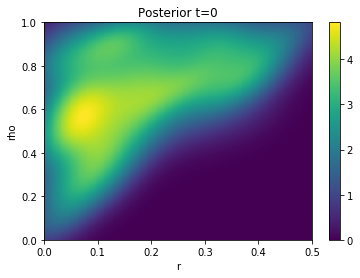

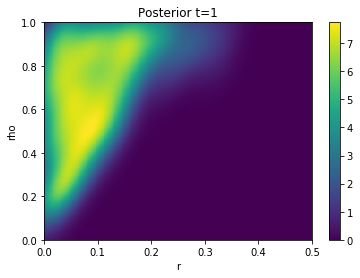

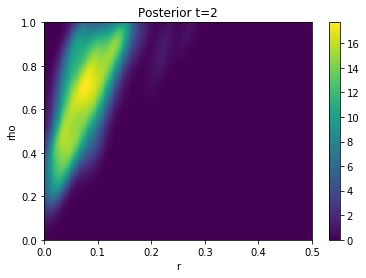

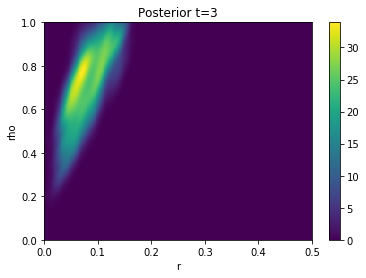

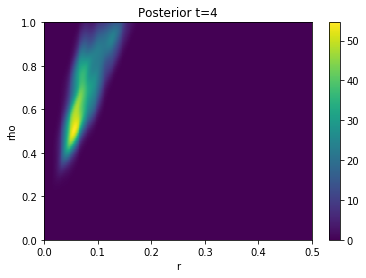

In [28]:
for t in range(h.max_t+1):
    ax = plot_kde_2d(*h.get_distribution(m=0, t=t),
                     "r", "rho",
                xmin=0, xmax=0.5, numx=300,
                ymin=0, ymax=1, numy=300)
    ax.set_title("Posterior t={}".format(t))

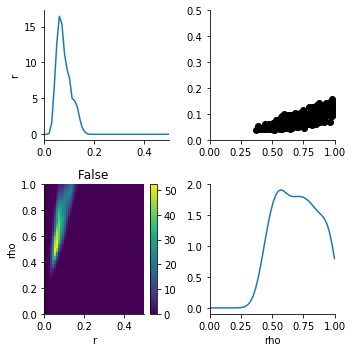

In [29]:
from pyabc.visualization import plot_kde_matrix

df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);